In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 831)
(3944610, 8)
validation
(464344, 831)
(464344, 8)
test
(574820, 831)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:54 - loss: 2.2018 - STD: 0.0716 - MAE: 0.2184

  5/395 [..............................] - ETA: 6s - loss: 2.0957 - STD: 0.0495 - MAE: 0.2167  

  9/395 [..............................] - ETA: 6s - loss: 2.0859 - STD: 0.0465 - MAE: 0.2166

 13/395 [..............................] - ETA: 6s - loss: 2.0749 - STD: 0.0423 - MAE: 0.2166

 17/395 [>.............................] - ETA: 6s - loss: 2.0694 - STD: 0.0404 - MAE: 0.2166

 21/395 [>.............................] - ETA: 6s - loss: 2.0637 - STD: 0.0390 - MAE: 0.2165

 25/395 [>.............................] - ETA: 5s - loss: 2.0572 - STD: 0.0379 - MAE: 0.2164

 29/395 [=>............................] - ETA: 5s - loss: 2.0482 - STD: 0.0378 - MAE: 0.2161

 33/395 [=>............................] - ETA: 5s - loss: 2.0358 - STD: 0.0387 - MAE: 0.2156

 37/395 [=>............................] - ETA: 5s - loss: 2.0212 - STD: 0.0409 - MAE: 0.2149

 41/395 [==>...........................] - ETA: 5s - loss: 2.0047 - STD: 0.0436 - MAE: 0.2140

 45/395 [==>...........................] - ETA: 5s - loss: 1.9862 - STD: 0.0466 - MAE: 0.2131

 49/395 [==>...........................] - ETA: 5s - loss: 1.9654 - STD: 0.0496 - MAE: 0.2120

 53/395 [===>..........................] - ETA: 5s - loss: 1.9431 - STD: 0.0530 - MAE: 0.2108

 57/395 [===>..........................] - ETA: 5s - loss: 1.9197 - STD: 0.0567 - MAE: 0.2095

 60/395 [===>..........................] - ETA: 5s - loss: 1.9024 - STD: 0.0596 - MAE: 0.2084

 64/395 [===>..........................] - ETA: 5s - loss: 1.8799 - STD: 0.0634 - MAE: 0.2070

 68/395 [====>.........................] - ETA: 5s - loss: 1.8582 - STD: 0.0671 - MAE: 0.2056

 72/395 [====>.........................] - ETA: 5s - loss: 1.8378 - STD: 0.0706 - MAE: 0.2043

 76/395 [====>.........................] - ETA: 4s - loss: 1.8187 - STD: 0.0739 - MAE: 0.2030

 80/395 [=====>........................] - ETA: 4s - loss: 1.8010 - STD: 0.0769 - MAE: 0.2018

 84/395 [=====>........................] - ETA: 4s - loss: 1.7841 - STD: 0.0798 - MAE: 0.2007

 88/395 [=====>........................] - ETA: 4s - loss: 1.7682 - STD: 0.0825 - MAE: 0.1996

 92/395 [=====>........................] - ETA: 4s - loss: 1.7534 - STD: 0.0850 - MAE: 0.1986

 96/395 [======>.......................] - ETA: 4s - loss: 1.7391 - STD: 0.0875 - MAE: 0.1976

100/395 [======>.......................] - ETA: 4s - loss: 1.7254 - STD: 0.0898 - MAE: 0.1966

104/395 [======>.......................] - ETA: 4s - loss: 1.7123 - STD: 0.0920 - MAE: 0.1956

108/395 [=======>......................] - ETA: 4s - loss: 1.6998 - STD: 0.0941 - MAE: 0.1947

112/395 [=======>......................] - ETA: 4s - loss: 1.6881 - STD: 0.0962 - MAE: 0.1938

115/395 [=======>......................] - ETA: 4s - loss: 1.6797 - STD: 0.0976 - MAE: 0.1932

119/395 [========>.....................] - ETA: 4s - loss: 1.6684 - STD: 0.0995 - MAE: 0.1924

123/395 [========>.....................] - ETA: 4s - loss: 1.6578 - STD: 0.1013 - MAE: 0.1916

126/395 [========>.....................] - ETA: 4s - loss: 1.6501 - STD: 0.1026 - MAE: 0.1910

130/395 [========>.....................] - ETA: 4s - loss: 1.6400 - STD: 0.1043 - MAE: 0.1902

134/395 [=========>....................] - ETA: 4s - loss: 1.6306 - STD: 0.1060 - MAE: 0.1894

138/395 [=========>....................] - ETA: 4s - loss: 1.6217 - STD: 0.1076 - MAE: 0.1887

141/395 [=========>....................] - ETA: 4s - loss: 1.6150 - STD: 0.1088 - MAE: 0.1881

144/395 [=========>....................] - ETA: 3s - loss: 1.6083 - STD: 0.1099 - MAE: 0.1876

147/395 [==========>...................] - ETA: 3s - loss: 1.6020 - STD: 0.1110 - MAE: 0.1871

150/395 [==========>...................] - ETA: 3s - loss: 1.5957 - STD: 0.1121 - MAE: 0.1865

153/395 [==========>...................] - ETA: 3s - loss: 1.5895 - STD: 0.1132 - MAE: 0.1860

156/395 [==========>...................] - ETA: 3s - loss: 1.5835 - STD: 0.1142 - MAE: 0.1855

159/395 [===========>..................] - ETA: 3s - loss: 1.5777 - STD: 0.1152 - MAE: 0.1851

163/395 [===========>..................] - ETA: 3s - loss: 1.5700 - STD: 0.1166 - MAE: 0.1844

167/395 [===========>..................] - ETA: 3s - loss: 1.5626 - STD: 0.1178 - MAE: 0.1838

171/395 [===========>..................] - ETA: 3s - loss: 1.5554 - STD: 0.1191 - MAE: 0.1832

175/395 [============>.................] - ETA: 3s - loss: 1.5486 - STD: 0.1203 - MAE: 0.1826

178/395 [============>.................] - ETA: 3s - loss: 1.5437 - STD: 0.1212 - MAE: 0.1822

182/395 [============>.................] - ETA: 3s - loss: 1.5374 - STD: 0.1223 - MAE: 0.1816

185/395 [=============>................] - ETA: 3s - loss: 1.5330 - STD: 0.1231 - MAE: 0.1812

189/395 [=============>................] - ETA: 3s - loss: 1.5271 - STD: 0.1242 - MAE: 0.1807

193/395 [=============>................] - ETA: 3s - loss: 1.5210 - STD: 0.1252 - MAE: 0.1802

197/395 [=============>................] - ETA: 3s - loss: 1.5154 - STD: 0.1262 - MAE: 0.1797

201/395 [==============>...............] - ETA: 3s - loss: 1.5100 - STD: 0.1272 - MAE: 0.1792

205/395 [==============>...............] - ETA: 3s - loss: 1.5048 - STD: 0.1281 - MAE: 0.1788

209/395 [==============>...............] - ETA: 2s - loss: 1.4996 - STD: 0.1291 - MAE: 0.1783

213/395 [===============>..............] - ETA: 2s - loss: 1.4944 - STD: 0.1300 - MAE: 0.1779

217/395 [===============>..............] - ETA: 2s - loss: 1.4895 - STD: 0.1308 - MAE: 0.1774

221/395 [===============>..............] - ETA: 2s - loss: 1.4844 - STD: 0.1317 - MAE: 0.1770

225/395 [================>.............] - ETA: 2s - loss: 1.4795 - STD: 0.1325 - MAE: 0.1766

229/395 [================>.............] - ETA: 2s - loss: 1.4748 - STD: 0.1333 - MAE: 0.1762

233/395 [================>.............] - ETA: 2s - loss: 1.4703 - STD: 0.1341 - MAE: 0.1758

237/395 [=================>............] - ETA: 2s - loss: 1.4659 - STD: 0.1349 - MAE: 0.1754

241/395 [=================>............] - ETA: 2s - loss: 1.4616 - STD: 0.1356 - MAE: 0.1750

245/395 [=================>............] - ETA: 2s - loss: 1.4573 - STD: 0.1363 - MAE: 0.1746

249/395 [=================>............] - ETA: 2s - loss: 1.4532 - STD: 0.1370 - MAE: 0.1742

253/395 [==================>...........] - ETA: 2s - loss: 1.4491 - STD: 0.1377 - MAE: 0.1739

257/395 [==================>...........] - ETA: 2s - loss: 1.4460 - STD: 0.1384 - MAE: 0.1736

260/395 [==================>...........] - ETA: 2s - loss: 1.4434 - STD: 0.1389 - MAE: 0.1733

263/395 [==================>...........] - ETA: 2s - loss: 1.4407 - STD: 0.1394 - MAE: 0.1731

267/395 [===================>..........] - ETA: 2s - loss: 1.4372 - STD: 0.1400 - MAE: 0.1728

271/395 [===================>..........] - ETA: 1s - loss: 1.4336 - STD: 0.1406 - MAE: 0.1724

275/395 [===================>..........] - ETA: 1s - loss: 1.4300 - STD: 0.1412 - MAE: 0.1721

279/395 [====================>.........] - ETA: 1s - loss: 1.4266 - STD: 0.1418 - MAE: 0.1718

282/395 [====================>.........] - ETA: 1s - loss: 1.4240 - STD: 0.1423 - MAE: 0.1716

285/395 [====================>.........] - ETA: 1s - loss: 1.4215 - STD: 0.1427 - MAE: 0.1714

288/395 [====================>.........] - ETA: 1s - loss: 1.4190 - STD: 0.1431 - MAE: 0.1711

289/395 [====================>.........] - ETA: 1s - loss: 1.4186 - STD: 0.1432 - MAE: 0.1711

293/395 [=====================>........] - ETA: 1s - loss: 1.4153 - STD: 0.1438 - MAE: 0.1708

297/395 [=====================>........] - ETA: 1s - loss: 1.4122 - STD: 0.1443 - MAE: 0.1705

301/395 [=====================>........] - ETA: 1s - loss: 1.4090 - STD: 0.1448 - MAE: 0.1702

304/395 [======================>.......] - ETA: 1s - loss: 1.4067 - STD: 0.1452 - MAE: 0.1700

307/395 [======================>.......] - ETA: 1s - loss: 1.4044 - STD: 0.1456 - MAE: 0.1698

310/395 [======================>.......] - ETA: 1s - loss: 1.4020 - STD: 0.1460 - MAE: 0.1696

313/395 [======================>.......] - ETA: 1s - loss: 1.3997 - STD: 0.1464 - MAE: 0.1694

317/395 [=======================>......] - ETA: 1s - loss: 1.3966 - STD: 0.1469 - MAE: 0.1691

321/395 [=======================>......] - ETA: 1s - loss: 1.3936 - STD: 0.1474 - MAE: 0.1688

325/395 [=======================>......] - ETA: 1s - loss: 1.3906 - STD: 0.1479 - MAE: 0.1686

329/395 [=======================>......] - ETA: 1s - loss: 1.3877 - STD: 0.1483 - MAE: 0.1683

333/395 [========================>.....] - ETA: 1s - loss: 1.3865 - STD: 0.1488 - MAE: 0.1681

337/395 [========================>.....] - ETA: 1s - loss: 1.3843 - STD: 0.1493 - MAE: 0.1679

341/395 [========================>.....] - ETA: 0s - loss: 1.3820 - STD: 0.1497 - MAE: 0.1677

344/395 [=========================>....] - ETA: 0s - loss: 1.3801 - STD: 0.1500 - MAE: 0.1675

348/395 [=========================>....] - ETA: 0s - loss: 1.3775 - STD: 0.1504 - MAE: 0.1673

352/395 [=========================>....] - ETA: 0s - loss: 1.3752 - STD: 0.1509 - MAE: 0.1671

356/395 [==========================>...] - ETA: 0s - loss: 1.3726 - STD: 0.1513 - MAE: 0.1668

360/395 [==========================>...] - ETA: 0s - loss: 1.3701 - STD: 0.1517 - MAE: 0.1666

364/395 [==========================>...] - ETA: 0s - loss: 1.3676 - STD: 0.1521 - MAE: 0.1664

368/395 [==========================>...] - ETA: 0s - loss: 1.3651 - STD: 0.1525 - MAE: 0.1662

372/395 [===========================>..] - ETA: 0s - loss: 1.3626 - STD: 0.1529 - MAE: 0.1659

376/395 [===========================>..] - ETA: 0s - loss: 1.3601 - STD: 0.1533 - MAE: 0.1657

380/395 [===========================>..] - ETA: 0s - loss: 1.3578 - STD: 0.1536 - MAE: 0.1655

384/395 [============================>.] - ETA: 0s - loss: 1.3554 - STD: 0.1540 - MAE: 0.1653

388/395 [============================>.] - ETA: 0s - loss: 1.3531 - STD: 0.1544 - MAE: 0.1651

392/395 [============================>.] - ETA: 0s - loss: 1.3508 - STD: 0.1548 - MAE: 0.1649

395/395 [==============================] - 9s 21ms/step - loss: 1.3492 - STD: 0.1550 - MAE: 0.1647 - val_loss: 1.1460 - val_STD: 0.1915 - val_MAE: 0.1435


Epoch 2/10000


  1/395 [..............................] - ETA: 20s - loss: 1.1237 - STD: 0.1909 - MAE: 0.1441

  4/395 [..............................] - ETA: 6s - loss: 1.1276 - STD: 0.1915 - MAE: 0.1441 

  7/395 [..............................] - ETA: 6s - loss: 1.1252 - STD: 0.1914 - MAE: 0.1440

 10/395 [..............................] - ETA: 6s - loss: 1.1257 - STD: 0.1912 - MAE: 0.1442

 14/395 [>.............................] - ETA: 6s - loss: 1.1300 - STD: 0.1911 - MAE: 0.1445

 18/395 [>.............................] - ETA: 6s - loss: 1.1268 - STD: 0.1912 - MAE: 0.1443

 22/395 [>.............................] - ETA: 6s - loss: 1.1255 - STD: 0.1915 - MAE: 0.1441

 26/395 [>.............................] - ETA: 5s - loss: 1.1243 - STD: 0.1916 - MAE: 0.1440

 29/395 [=>............................] - ETA: 5s - loss: 1.1232 - STD: 0.1916 - MAE: 0.1439

 32/395 [=>............................] - ETA: 5s - loss: 1.1217 - STD: 0.1917 - MAE: 0.1438

 35/395 [=>............................] - ETA: 5s - loss: 1.1214 - STD: 0.1918 - MAE: 0.1438

 38/395 [=>............................] - ETA: 5s - loss: 1.1207 - STD: 0.1919 - MAE: 0.1437

 42/395 [==>...........................] - ETA: 5s - loss: 1.1222 - STD: 0.1920 - MAE: 0.1437

 46/395 [==>...........................] - ETA: 5s - loss: 1.1223 - STD: 0.1921 - MAE: 0.1437

 50/395 [==>...........................] - ETA: 5s - loss: 1.1226 - STD: 0.1922 - MAE: 0.1437

 54/395 [===>..........................] - ETA: 5s - loss: 1.1215 - STD: 0.1922 - MAE: 0.1436

 58/395 [===>..........................] - ETA: 5s - loss: 1.1212 - STD: 0.1923 - MAE: 0.1436

 62/395 [===>..........................] - ETA: 5s - loss: 1.1202 - STD: 0.1925 - MAE: 0.1435

 66/395 [====>.........................] - ETA: 5s - loss: 1.1188 - STD: 0.1926 - MAE: 0.1434

 70/395 [====>.........................] - ETA: 5s - loss: 1.1204 - STD: 0.1927 - MAE: 0.1434

 73/395 [====>.........................] - ETA: 5s - loss: 1.1198 - STD: 0.1928 - MAE: 0.1433

 77/395 [====>.........................] - ETA: 5s - loss: 1.1202 - STD: 0.1929 - MAE: 0.1433

 81/395 [=====>........................] - ETA: 5s - loss: 1.1204 - STD: 0.1930 - MAE: 0.1433

 85/395 [=====>........................] - ETA: 5s - loss: 1.1205 - STD: 0.1930 - MAE: 0.1433

 89/395 [=====>........................] - ETA: 4s - loss: 1.1202 - STD: 0.1930 - MAE: 0.1433

 93/395 [======>.......................] - ETA: 4s - loss: 1.1195 - STD: 0.1931 - MAE: 0.1432

 97/395 [======>.......................] - ETA: 4s - loss: 1.1188 - STD: 0.1932 - MAE: 0.1431

101/395 [======>.......................] - ETA: 4s - loss: 1.1178 - STD: 0.1932 - MAE: 0.1431

105/395 [======>.......................] - ETA: 4s - loss: 1.1167 - STD: 0.1933 - MAE: 0.1430

109/395 [=======>......................] - ETA: 4s - loss: 1.1158 - STD: 0.1934 - MAE: 0.1429

113/395 [=======>......................] - ETA: 4s - loss: 1.1147 - STD: 0.1935 - MAE: 0.1428

117/395 [=======>......................] - ETA: 4s - loss: 1.1138 - STD: 0.1935 - MAE: 0.1427

121/395 [========>.....................] - ETA: 4s - loss: 1.1130 - STD: 0.1936 - MAE: 0.1427

125/395 [========>.....................] - ETA: 4s - loss: 1.1124 - STD: 0.1937 - MAE: 0.1426

129/395 [========>.....................] - ETA: 4s - loss: 1.1115 - STD: 0.1938 - MAE: 0.1425

133/395 [=========>....................] - ETA: 4s - loss: 1.1106 - STD: 0.1939 - MAE: 0.1424

137/395 [=========>....................] - ETA: 4s - loss: 1.1100 - STD: 0.1939 - MAE: 0.1424

141/395 [=========>....................] - ETA: 4s - loss: 1.1089 - STD: 0.1940 - MAE: 0.1423

144/395 [=========>....................] - ETA: 3s - loss: 1.1083 - STD: 0.1941 - MAE: 0.1423

148/395 [==========>...................] - ETA: 3s - loss: 1.1100 - STD: 0.1942 - MAE: 0.1423

152/395 [==========>...................] - ETA: 3s - loss: 1.1107 - STD: 0.1942 - MAE: 0.1423

156/395 [==========>...................] - ETA: 3s - loss: 1.1103 - STD: 0.1943 - MAE: 0.1423

160/395 [===========>..................] - ETA: 3s - loss: 1.1098 - STD: 0.1944 - MAE: 0.1422

163/395 [===========>..................] - ETA: 3s - loss: 1.1094 - STD: 0.1944 - MAE: 0.1422

166/395 [===========>..................] - ETA: 3s - loss: 1.1090 - STD: 0.1944 - MAE: 0.1422

169/395 [===========>..................] - ETA: 3s - loss: 1.1085 - STD: 0.1944 - MAE: 0.1421

172/395 [============>.................] - ETA: 3s - loss: 1.1078 - STD: 0.1945 - MAE: 0.1421

175/395 [============>.................] - ETA: 3s - loss: 1.1071 - STD: 0.1945 - MAE: 0.1420

179/395 [============>.................] - ETA: 3s - loss: 1.1062 - STD: 0.1946 - MAE: 0.1420

183/395 [============>.................] - ETA: 3s - loss: 1.1056 - STD: 0.1947 - MAE: 0.1419

187/395 [=============>................] - ETA: 3s - loss: 1.1048 - STD: 0.1947 - MAE: 0.1418

191/395 [=============>................] - ETA: 3s - loss: 1.1040 - STD: 0.1948 - MAE: 0.1418

195/395 [=============>................] - ETA: 3s - loss: 1.1033 - STD: 0.1949 - MAE: 0.1417

199/395 [==============>...............] - ETA: 3s - loss: 1.1026 - STD: 0.1950 - MAE: 0.1416

203/395 [==============>...............] - ETA: 3s - loss: 1.1019 - STD: 0.1950 - MAE: 0.1416

206/395 [==============>...............] - ETA: 3s - loss: 1.1017 - STD: 0.1951 - MAE: 0.1416

210/395 [==============>...............] - ETA: 2s - loss: 1.1013 - STD: 0.1951 - MAE: 0.1415

213/395 [===============>..............] - ETA: 2s - loss: 1.1008 - STD: 0.1952 - MAE: 0.1415

217/395 [===============>..............] - ETA: 2s - loss: 1.1002 - STD: 0.1953 - MAE: 0.1414

220/395 [===============>..............] - ETA: 2s - loss: 1.0997 - STD: 0.1953 - MAE: 0.1414

224/395 [================>.............] - ETA: 2s - loss: 1.0993 - STD: 0.1954 - MAE: 0.1413

228/395 [================>.............] - ETA: 2s - loss: 1.0985 - STD: 0.1955 - MAE: 0.1412

232/395 [================>.............] - ETA: 2s - loss: 1.0982 - STD: 0.1955 - MAE: 0.1412

236/395 [================>.............] - ETA: 2s - loss: 1.0982 - STD: 0.1956 - MAE: 0.1412

239/395 [=================>............] - ETA: 2s - loss: 1.0980 - STD: 0.1956 - MAE: 0.1411

242/395 [=================>............] - ETA: 2s - loss: 1.0979 - STD: 0.1957 - MAE: 0.1411

246/395 [=================>............] - ETA: 2s - loss: 1.0976 - STD: 0.1957 - MAE: 0.1411

250/395 [=================>............] - ETA: 2s - loss: 1.0972 - STD: 0.1958 - MAE: 0.1410

254/395 [==================>...........] - ETA: 2s - loss: 1.0967 - STD: 0.1958 - MAE: 0.1410

258/395 [==================>...........] - ETA: 2s - loss: 1.0961 - STD: 0.1959 - MAE: 0.1409

262/395 [==================>...........] - ETA: 2s - loss: 1.0956 - STD: 0.1959 - MAE: 0.1409

266/395 [===================>..........] - ETA: 2s - loss: 1.0950 - STD: 0.1960 - MAE: 0.1409

270/395 [===================>..........] - ETA: 2s - loss: 1.0942 - STD: 0.1960 - MAE: 0.1408

274/395 [===================>..........] - ETA: 1s - loss: 1.0935 - STD: 0.1961 - MAE: 0.1407

278/395 [====================>.........] - ETA: 1s - loss: 1.0930 - STD: 0.1961 - MAE: 0.1407

282/395 [====================>.........] - ETA: 1s - loss: 1.0924 - STD: 0.1962 - MAE: 0.1406

286/395 [====================>.........] - ETA: 1s - loss: 1.0918 - STD: 0.1963 - MAE: 0.1406

290/395 [=====================>........] - ETA: 1s - loss: 1.0913 - STD: 0.1963 - MAE: 0.1405

294/395 [=====================>........] - ETA: 1s - loss: 1.0909 - STD: 0.1964 - MAE: 0.1405

298/395 [=====================>........] - ETA: 1s - loss: 1.0905 - STD: 0.1964 - MAE: 0.1404

302/395 [=====================>........] - ETA: 1s - loss: 1.0899 - STD: 0.1965 - MAE: 0.1404

306/395 [======================>.......] - ETA: 1s - loss: 1.0892 - STD: 0.1966 - MAE: 0.1403

310/395 [======================>.......] - ETA: 1s - loss: 1.0886 - STD: 0.1966 - MAE: 0.1403

314/395 [======================>.......] - ETA: 1s - loss: 1.0881 - STD: 0.1967 - MAE: 0.1402

318/395 [=======================>......] - ETA: 1s - loss: 1.0877 - STD: 0.1967 - MAE: 0.1402

322/395 [=======================>......] - ETA: 1s - loss: 1.0871 - STD: 0.1968 - MAE: 0.1401

326/395 [=======================>......] - ETA: 1s - loss: 1.0864 - STD: 0.1969 - MAE: 0.1401

330/395 [========================>.....] - ETA: 1s - loss: 1.0858 - STD: 0.1969 - MAE: 0.1400

334/395 [========================>.....] - ETA: 0s - loss: 1.0854 - STD: 0.1970 - MAE: 0.1400

338/395 [========================>.....] - ETA: 0s - loss: 1.0847 - STD: 0.1970 - MAE: 0.1399

342/395 [========================>.....] - ETA: 0s - loss: 1.0841 - STD: 0.1971 - MAE: 0.1399

346/395 [=========================>....] - ETA: 0s - loss: 1.0840 - STD: 0.1972 - MAE: 0.1398

350/395 [=========================>....] - ETA: 0s - loss: 1.0837 - STD: 0.1972 - MAE: 0.1398

354/395 [=========================>....] - ETA: 0s - loss: 1.0832 - STD: 0.1973 - MAE: 0.1397

358/395 [==========================>...] - ETA: 0s - loss: 1.0826 - STD: 0.1974 - MAE: 0.1397

362/395 [==========================>...] - ETA: 0s - loss: 1.0819 - STD: 0.1974 - MAE: 0.1396

366/395 [==========================>...] - ETA: 0s - loss: 1.0814 - STD: 0.1975 - MAE: 0.1396

370/395 [===========================>..] - ETA: 0s - loss: 1.0809 - STD: 0.1975 - MAE: 0.1395

374/395 [===========================>..] - ETA: 0s - loss: 1.0804 - STD: 0.1976 - MAE: 0.1395

378/395 [===========================>..] - ETA: 0s - loss: 1.0798 - STD: 0.1977 - MAE: 0.1394

381/395 [===========================>..] - ETA: 0s - loss: 1.0794 - STD: 0.1977 - MAE: 0.1394

384/395 [============================>.] - ETA: 0s - loss: 1.0789 - STD: 0.1977 - MAE: 0.1393

388/395 [============================>.] - ETA: 0s - loss: 1.0783 - STD: 0.1978 - MAE: 0.1393

392/395 [============================>.] - ETA: 0s - loss: 1.0779 - STD: 0.1979 - MAE: 0.1392

395/395 [==============================] - 7s 18ms/step - loss: 1.0774 - STD: 0.1979 - MAE: 0.1392 - val_loss: 1.0978 - val_STD: 0.2055 - val_MAE: 0.1369


Epoch 3/10000


  1/395 [..............................] - ETA: 19s - loss: 1.0299 - STD: 0.2042 - MAE: 0.1343

  4/395 [..............................] - ETA: 7s - loss: 1.0235 - STD: 0.2038 - MAE: 0.1341 

  8/395 [..............................] - ETA: 6s - loss: 1.0272 - STD: 0.2042 - MAE: 0.1341

 11/395 [..............................] - ETA: 6s - loss: 1.0251 - STD: 0.2043 - MAE: 0.1339

 14/395 [>.............................] - ETA: 6s - loss: 1.0234 - STD: 0.2044 - MAE: 0.1338

 17/395 [>.............................] - ETA: 6s - loss: 1.0251 - STD: 0.2045 - MAE: 0.1339

 21/395 [>.............................] - ETA: 6s - loss: 1.0218 - STD: 0.2045 - MAE: 0.1337

 24/395 [>.............................] - ETA: 6s - loss: 1.0210 - STD: 0.2046 - MAE: 0.1336

 27/395 [=>............................] - ETA: 6s - loss: 1.0240 - STD: 0.2045 - MAE: 0.1337

 30/395 [=>............................] - ETA: 6s - loss: 1.0252 - STD: 0.2046 - MAE: 0.1338

 33/395 [=>............................] - ETA: 6s - loss: 1.0275 - STD: 0.2045 - MAE: 0.1339

 36/395 [=>............................] - ETA: 6s - loss: 1.0256 - STD: 0.2045 - MAE: 0.1338

 39/395 [=>............................] - ETA: 6s - loss: 1.0250 - STD: 0.2045 - MAE: 0.1338

 42/395 [==>...........................] - ETA: 6s - loss: 1.0235 - STD: 0.2045 - MAE: 0.1337

 45/395 [==>...........................] - ETA: 6s - loss: 1.0223 - STD: 0.2046 - MAE: 0.1336

 48/395 [==>...........................] - ETA: 6s - loss: 1.0224 - STD: 0.2046 - MAE: 0.1336

 51/395 [==>...........................] - ETA: 6s - loss: 1.0222 - STD: 0.2046 - MAE: 0.1336

 54/395 [===>..........................] - ETA: 6s - loss: 1.0220 - STD: 0.2047 - MAE: 0.1335

 57/395 [===>..........................] - ETA: 5s - loss: 1.0213 - STD: 0.2046 - MAE: 0.1335

 60/395 [===>..........................] - ETA: 5s - loss: 1.0221 - STD: 0.2047 - MAE: 0.1336

 63/395 [===>..........................] - ETA: 5s - loss: 1.0214 - STD: 0.2047 - MAE: 0.1335

 66/395 [====>.........................] - ETA: 5s - loss: 1.0214 - STD: 0.2047 - MAE: 0.1335

 69/395 [====>.........................] - ETA: 5s - loss: 1.0214 - STD: 0.2048 - MAE: 0.1335

 72/395 [====>.........................] - ETA: 5s - loss: 1.0215 - STD: 0.2048 - MAE: 0.1335

 75/395 [====>.........................] - ETA: 5s - loss: 1.0211 - STD: 0.2049 - MAE: 0.1334

 78/395 [====>.........................] - ETA: 5s - loss: 1.0220 - STD: 0.2050 - MAE: 0.1334

 81/395 [=====>........................] - ETA: 5s - loss: 1.0221 - STD: 0.2050 - MAE: 0.1334

 84/395 [=====>........................] - ETA: 5s - loss: 1.0219 - STD: 0.2049 - MAE: 0.1335

 87/395 [=====>........................] - ETA: 5s - loss: 1.0223 - STD: 0.2049 - MAE: 0.1335

 91/395 [=====>........................] - ETA: 5s - loss: 1.0228 - STD: 0.2050 - MAE: 0.1335

 94/395 [======>.......................] - ETA: 5s - loss: 1.0228 - STD: 0.2050 - MAE: 0.1335

 97/395 [======>.......................] - ETA: 5s - loss: 1.0230 - STD: 0.2051 - MAE: 0.1335

100/395 [======>.......................] - ETA: 5s - loss: 1.0224 - STD: 0.2050 - MAE: 0.1334

103/395 [======>.......................] - ETA: 5s - loss: 1.0220 - STD: 0.2050 - MAE: 0.1334

106/395 [=======>......................] - ETA: 5s - loss: 1.0218 - STD: 0.2051 - MAE: 0.1334

109/395 [=======>......................] - ETA: 5s - loss: 1.0221 - STD: 0.2051 - MAE: 0.1334

112/395 [=======>......................] - ETA: 5s - loss: 1.0225 - STD: 0.2051 - MAE: 0.1334

115/395 [=======>......................] - ETA: 4s - loss: 1.0226 - STD: 0.2051 - MAE: 0.1334

118/395 [=======>......................] - ETA: 4s - loss: 1.0224 - STD: 0.2051 - MAE: 0.1334

121/395 [========>.....................] - ETA: 4s - loss: 1.0220 - STD: 0.2052 - MAE: 0.1334

124/395 [========>.....................] - ETA: 4s - loss: 1.0220 - STD: 0.2052 - MAE: 0.1334

127/395 [========>.....................] - ETA: 4s - loss: 1.0216 - STD: 0.2052 - MAE: 0.1333

131/395 [========>.....................] - ETA: 4s - loss: 1.0213 - STD: 0.2052 - MAE: 0.1333

134/395 [=========>....................] - ETA: 4s - loss: 1.0211 - STD: 0.2052 - MAE: 0.1333

137/395 [=========>....................] - ETA: 4s - loss: 1.0206 - STD: 0.2053 - MAE: 0.1332

140/395 [=========>....................] - ETA: 4s - loss: 1.0200 - STD: 0.2053 - MAE: 0.1332

143/395 [=========>....................] - ETA: 4s - loss: 1.0195 - STD: 0.2053 - MAE: 0.1332

146/395 [==========>...................] - ETA: 4s - loss: 1.0190 - STD: 0.2054 - MAE: 0.1331

149/395 [==========>...................] - ETA: 4s - loss: 1.0185 - STD: 0.2054 - MAE: 0.1331

152/395 [==========>...................] - ETA: 4s - loss: 1.0181 - STD: 0.2054 - MAE: 0.1330

155/395 [==========>...................] - ETA: 4s - loss: 1.0176 - STD: 0.2055 - MAE: 0.1330

158/395 [===========>..................] - ETA: 4s - loss: 1.0168 - STD: 0.2055 - MAE: 0.1329

161/395 [===========>..................] - ETA: 4s - loss: 1.0161 - STD: 0.2056 - MAE: 0.1329

164/395 [===========>..................] - ETA: 4s - loss: 1.0156 - STD: 0.2056 - MAE: 0.1328

167/395 [===========>..................] - ETA: 4s - loss: 1.0151 - STD: 0.2056 - MAE: 0.1328

170/395 [===========>..................] - ETA: 3s - loss: 1.0146 - STD: 0.2057 - MAE: 0.1327

173/395 [============>.................] - ETA: 3s - loss: 1.0144 - STD: 0.2057 - MAE: 0.1327

176/395 [============>.................] - ETA: 3s - loss: 1.0139 - STD: 0.2058 - MAE: 0.1327

179/395 [============>.................] - ETA: 3s - loss: 1.0135 - STD: 0.2058 - MAE: 0.1326

182/395 [============>.................] - ETA: 3s - loss: 1.0132 - STD: 0.2058 - MAE: 0.1326

185/395 [=============>................] - ETA: 3s - loss: 1.0129 - STD: 0.2059 - MAE: 0.1326

188/395 [=============>................] - ETA: 3s - loss: 1.0124 - STD: 0.2059 - MAE: 0.1325

191/395 [=============>................] - ETA: 3s - loss: 1.0128 - STD: 0.2060 - MAE: 0.1325

194/395 [=============>................] - ETA: 3s - loss: 1.0125 - STD: 0.2060 - MAE: 0.1325

197/395 [=============>................] - ETA: 3s - loss: 1.0124 - STD: 0.2061 - MAE: 0.1325

200/395 [==============>...............] - ETA: 3s - loss: 1.0122 - STD: 0.2061 - MAE: 0.1324

203/395 [==============>...............] - ETA: 3s - loss: 1.0119 - STD: 0.2062 - MAE: 0.1324

206/395 [==============>...............] - ETA: 3s - loss: 1.0115 - STD: 0.2062 - MAE: 0.1324

209/395 [==============>...............] - ETA: 3s - loss: 1.0111 - STD: 0.2062 - MAE: 0.1323

212/395 [===============>..............] - ETA: 3s - loss: 1.0107 - STD: 0.2063 - MAE: 0.1323

215/395 [===============>..............] - ETA: 3s - loss: 1.0103 - STD: 0.2063 - MAE: 0.1322

218/395 [===============>..............] - ETA: 3s - loss: 1.0100 - STD: 0.2063 - MAE: 0.1322

221/395 [===============>..............] - ETA: 3s - loss: 1.0095 - STD: 0.2064 - MAE: 0.1322

224/395 [================>.............] - ETA: 3s - loss: 1.0092 - STD: 0.2064 - MAE: 0.1321

227/395 [================>.............] - ETA: 2s - loss: 1.0089 - STD: 0.2064 - MAE: 0.1321

230/395 [================>.............] - ETA: 2s - loss: 1.0086 - STD: 0.2065 - MAE: 0.1321

233/395 [================>.............] - ETA: 2s - loss: 1.0081 - STD: 0.2065 - MAE: 0.1320

237/395 [=================>............] - ETA: 2s - loss: 1.0076 - STD: 0.2066 - MAE: 0.1320

240/395 [=================>............] - ETA: 2s - loss: 1.0072 - STD: 0.2066 - MAE: 0.1319

243/395 [=================>............] - ETA: 2s - loss: 1.0068 - STD: 0.2067 - MAE: 0.1319

246/395 [=================>............] - ETA: 2s - loss: 1.0063 - STD: 0.2067 - MAE: 0.1319

249/395 [=================>............] - ETA: 2s - loss: 1.0058 - STD: 0.2068 - MAE: 0.1318

252/395 [==================>...........] - ETA: 2s - loss: 1.0055 - STD: 0.2068 - MAE: 0.1318

255/395 [==================>...........] - ETA: 2s - loss: 1.0050 - STD: 0.2068 - MAE: 0.1317

258/395 [==================>...........] - ETA: 2s - loss: 1.0046 - STD: 0.2069 - MAE: 0.1317

261/395 [==================>...........] - ETA: 2s - loss: 1.0042 - STD: 0.2069 - MAE: 0.1316

264/395 [===================>..........] - ETA: 2s - loss: 1.0040 - STD: 0.2070 - MAE: 0.1316

267/395 [===================>..........] - ETA: 2s - loss: 1.0038 - STD: 0.2070 - MAE: 0.1316

270/395 [===================>..........] - ETA: 2s - loss: 1.0035 - STD: 0.2071 - MAE: 0.1316

273/395 [===================>..........] - ETA: 2s - loss: 1.0034 - STD: 0.2071 - MAE: 0.1315

276/395 [===================>..........] - ETA: 2s - loss: 1.0033 - STD: 0.2072 - MAE: 0.1315

279/395 [====================>.........] - ETA: 2s - loss: 1.0029 - STD: 0.2072 - MAE: 0.1315

282/395 [====================>.........] - ETA: 2s - loss: 1.0030 - STD: 0.2072 - MAE: 0.1314

285/395 [====================>.........] - ETA: 1s - loss: 1.0027 - STD: 0.2073 - MAE: 0.1314

288/395 [====================>.........] - ETA: 1s - loss: 1.0024 - STD: 0.2073 - MAE: 0.1314

291/395 [=====================>........] - ETA: 1s - loss: 1.0020 - STD: 0.2073 - MAE: 0.1313

294/395 [=====================>........] - ETA: 1s - loss: 1.0016 - STD: 0.2074 - MAE: 0.1313

297/395 [=====================>........] - ETA: 1s - loss: 1.0013 - STD: 0.2074 - MAE: 0.1313

300/395 [=====================>........] - ETA: 1s - loss: 1.0010 - STD: 0.2074 - MAE: 0.1312

304/395 [======================>.......] - ETA: 1s - loss: 1.0007 - STD: 0.2075 - MAE: 0.1312

307/395 [======================>.......] - ETA: 1s - loss: 1.0002 - STD: 0.2075 - MAE: 0.1312

310/395 [======================>.......] - ETA: 1s - loss: 1.0000 - STD: 0.2075 - MAE: 0.1312

313/395 [======================>.......] - ETA: 1s - loss: 0.9997 - STD: 0.2076 - MAE: 0.1311

316/395 [=======================>......] - ETA: 1s - loss: 0.9993 - STD: 0.2076 - MAE: 0.1311

319/395 [=======================>......] - ETA: 1s - loss: 0.9990 - STD: 0.2077 - MAE: 0.1311

322/395 [=======================>......] - ETA: 1s - loss: 0.9987 - STD: 0.2077 - MAE: 0.1310

326/395 [=======================>......] - ETA: 1s - loss: 0.9986 - STD: 0.2077 - MAE: 0.1310

330/395 [========================>.....] - ETA: 1s - loss: 0.9984 - STD: 0.2078 - MAE: 0.1310

333/395 [========================>.....] - ETA: 1s - loss: 0.9981 - STD: 0.2078 - MAE: 0.1309

336/395 [========================>.....] - ETA: 1s - loss: 0.9978 - STD: 0.2078 - MAE: 0.1309

339/395 [========================>.....] - ETA: 0s - loss: 0.9978 - STD: 0.2079 - MAE: 0.1309

342/395 [========================>.....] - ETA: 0s - loss: 0.9975 - STD: 0.2079 - MAE: 0.1309

345/395 [=========================>....] - ETA: 0s - loss: 0.9977 - STD: 0.2079 - MAE: 0.1309

348/395 [=========================>....] - ETA: 0s - loss: 0.9977 - STD: 0.2080 - MAE: 0.1308

351/395 [=========================>....] - ETA: 0s - loss: 0.9975 - STD: 0.2080 - MAE: 0.1308

354/395 [=========================>....] - ETA: 0s - loss: 0.9972 - STD: 0.2080 - MAE: 0.1308

357/395 [==========================>...] - ETA: 0s - loss: 0.9970 - STD: 0.2081 - MAE: 0.1308

361/395 [==========================>...] - ETA: 0s - loss: 0.9967 - STD: 0.2081 - MAE: 0.1307

365/395 [==========================>...] - ETA: 0s - loss: 0.9966 - STD: 0.2081 - MAE: 0.1307

368/395 [==========================>...] - ETA: 0s - loss: 0.9963 - STD: 0.2082 - MAE: 0.1307

371/395 [===========================>..] - ETA: 0s - loss: 0.9961 - STD: 0.2082 - MAE: 0.1307

374/395 [===========================>..] - ETA: 0s - loss: 0.9958 - STD: 0.2082 - MAE: 0.1306

377/395 [===========================>..] - ETA: 0s - loss: 0.9956 - STD: 0.2082 - MAE: 0.1306

380/395 [===========================>..] - ETA: 0s - loss: 0.9952 - STD: 0.2083 - MAE: 0.1306

383/395 [============================>.] - ETA: 0s - loss: 0.9950 - STD: 0.2083 - MAE: 0.1306

386/395 [============================>.] - ETA: 0s - loss: 0.9948 - STD: 0.2083 - MAE: 0.1305

389/395 [============================>.] - ETA: 0s - loss: 0.9944 - STD: 0.2084 - MAE: 0.1305

392/395 [============================>.] - ETA: 0s - loss: 0.9942 - STD: 0.2084 - MAE: 0.1305

395/395 [==============================] - 8s 19ms/step - loss: 0.9940 - STD: 0.2084 - MAE: 0.1304 - val_loss: 1.0498 - val_STD: 0.2148 - val_MAE: 0.1308


Epoch 4/10000


  1/395 [..............................] - ETA: 19s - loss: 1.0006 - STD: 0.2150 - MAE: 0.1284

  4/395 [..............................] - ETA: 7s - loss: 0.9717 - STD: 0.2131 - MAE: 0.1274 

  8/395 [..............................] - ETA: 6s - loss: 0.9724 - STD: 0.2123 - MAE: 0.1276

 12/395 [..............................] - ETA: 6s - loss: 0.9674 - STD: 0.2121 - MAE: 0.1274

 16/395 [>.............................] - ETA: 6s - loss: 0.9647 - STD: 0.2123 - MAE: 0.1272

 19/395 [>.............................] - ETA: 6s - loss: 0.9608 - STD: 0.2124 - MAE: 0.1269

 22/395 [>.............................] - ETA: 6s - loss: 0.9581 - STD: 0.2125 - MAE: 0.1267

 25/395 [>.............................] - ETA: 6s - loss: 0.9565 - STD: 0.2126 - MAE: 0.1266

 28/395 [=>............................] - ETA: 6s - loss: 0.9549 - STD: 0.2126 - MAE: 0.1265

 31/395 [=>............................] - ETA: 6s - loss: 0.9546 - STD: 0.2127 - MAE: 0.1264

 34/395 [=>............................] - ETA: 6s - loss: 0.9545 - STD: 0.2128 - MAE: 0.1264

 37/395 [=>............................] - ETA: 6s - loss: 0.9543 - STD: 0.2128 - MAE: 0.1264

 40/395 [==>...........................] - ETA: 6s - loss: 0.9534 - STD: 0.2128 - MAE: 0.1263

 43/395 [==>...........................] - ETA: 6s - loss: 0.9529 - STD: 0.2129 - MAE: 0.1263

 46/395 [==>...........................] - ETA: 6s - loss: 0.9522 - STD: 0.2130 - MAE: 0.1262

 49/395 [==>...........................] - ETA: 6s - loss: 0.9516 - STD: 0.2130 - MAE: 0.1261

 52/395 [==>...........................] - ETA: 5s - loss: 0.9513 - STD: 0.2131 - MAE: 0.1261

 55/395 [===>..........................] - ETA: 5s - loss: 0.9525 - STD: 0.2131 - MAE: 0.1262

 58/395 [===>..........................] - ETA: 5s - loss: 0.9543 - STD: 0.2132 - MAE: 0.1262

 61/395 [===>..........................] - ETA: 5s - loss: 0.9544 - STD: 0.2133 - MAE: 0.1262

 64/395 [===>..........................] - ETA: 5s - loss: 0.9543 - STD: 0.2133 - MAE: 0.1261

 67/395 [====>.........................] - ETA: 5s - loss: 0.9544 - STD: 0.2134 - MAE: 0.1261

 70/395 [====>.........................] - ETA: 5s - loss: 0.9559 - STD: 0.2135 - MAE: 0.1262

 73/395 [====>.........................] - ETA: 5s - loss: 0.9560 - STD: 0.2135 - MAE: 0.1262

 76/395 [====>.........................] - ETA: 5s - loss: 0.9558 - STD: 0.2135 - MAE: 0.1262

 80/395 [=====>........................] - ETA: 5s - loss: 0.9558 - STD: 0.2135 - MAE: 0.1262

 83/395 [=====>........................] - ETA: 5s - loss: 0.9561 - STD: 0.2135 - MAE: 0.1262

 86/395 [=====>........................] - ETA: 5s - loss: 0.9556 - STD: 0.2136 - MAE: 0.1261

 89/395 [=====>........................] - ETA: 5s - loss: 0.9551 - STD: 0.2136 - MAE: 0.1261

 92/395 [=====>........................] - ETA: 5s - loss: 0.9548 - STD: 0.2136 - MAE: 0.1261

 95/395 [======>.......................] - ETA: 5s - loss: 0.9546 - STD: 0.2136 - MAE: 0.1261

 98/395 [======>.......................] - ETA: 5s - loss: 0.9542 - STD: 0.2136 - MAE: 0.1260

101/395 [======>.......................] - ETA: 5s - loss: 0.9541 - STD: 0.2137 - MAE: 0.1260

104/395 [======>.......................] - ETA: 5s - loss: 0.9540 - STD: 0.2137 - MAE: 0.1260

107/395 [=======>......................] - ETA: 5s - loss: 0.9541 - STD: 0.2137 - MAE: 0.1260

110/395 [=======>......................] - ETA: 5s - loss: 0.9539 - STD: 0.2137 - MAE: 0.1260

113/395 [=======>......................] - ETA: 4s - loss: 0.9538 - STD: 0.2138 - MAE: 0.1260

116/395 [=======>......................] - ETA: 4s - loss: 0.9538 - STD: 0.2138 - MAE: 0.1260

119/395 [========>.....................] - ETA: 4s - loss: 0.9536 - STD: 0.2138 - MAE: 0.1259

122/395 [========>.....................] - ETA: 4s - loss: 0.9533 - STD: 0.2138 - MAE: 0.1259

125/395 [========>.....................] - ETA: 4s - loss: 0.9532 - STD: 0.2139 - MAE: 0.1259

128/395 [========>.....................] - ETA: 4s - loss: 0.9529 - STD: 0.2138 - MAE: 0.1259

131/395 [========>.....................] - ETA: 4s - loss: 0.9524 - STD: 0.2139 - MAE: 0.1258

134/395 [=========>....................] - ETA: 4s - loss: 0.9523 - STD: 0.2139 - MAE: 0.1258

137/395 [=========>....................] - ETA: 4s - loss: 0.9517 - STD: 0.2139 - MAE: 0.1258

140/395 [=========>....................] - ETA: 4s - loss: 0.9512 - STD: 0.2140 - MAE: 0.1257

143/395 [=========>....................] - ETA: 4s - loss: 0.9508 - STD: 0.2140 - MAE: 0.1257

146/395 [==========>...................] - ETA: 4s - loss: 0.9506 - STD: 0.2140 - MAE: 0.1257

149/395 [==========>...................] - ETA: 4s - loss: 0.9504 - STD: 0.2141 - MAE: 0.1256

153/395 [==========>...................] - ETA: 4s - loss: 0.9501 - STD: 0.2141 - MAE: 0.1256

156/395 [==========>...................] - ETA: 4s - loss: 0.9496 - STD: 0.2142 - MAE: 0.1255

159/395 [===========>..................] - ETA: 4s - loss: 0.9492 - STD: 0.2142 - MAE: 0.1255

162/395 [===========>..................] - ETA: 4s - loss: 0.9488 - STD: 0.2143 - MAE: 0.1255

165/395 [===========>..................] - ETA: 4s - loss: 0.9490 - STD: 0.2143 - MAE: 0.1255

168/395 [===========>..................] - ETA: 3s - loss: 0.9487 - STD: 0.2143 - MAE: 0.1254

171/395 [===========>..................] - ETA: 3s - loss: 0.9485 - STD: 0.2143 - MAE: 0.1254

174/395 [============>.................] - ETA: 3s - loss: 0.9487 - STD: 0.2144 - MAE: 0.1254

177/395 [============>.................] - ETA: 3s - loss: 0.9485 - STD: 0.2144 - MAE: 0.1254

180/395 [============>.................] - ETA: 3s - loss: 0.9490 - STD: 0.2144 - MAE: 0.1254

183/395 [============>.................] - ETA: 3s - loss: 0.9490 - STD: 0.2144 - MAE: 0.1254

186/395 [=============>................] - ETA: 3s - loss: 0.9489 - STD: 0.2144 - MAE: 0.1254

189/395 [=============>................] - ETA: 3s - loss: 0.9491 - STD: 0.2144 - MAE: 0.1254

192/395 [=============>................] - ETA: 3s - loss: 0.9492 - STD: 0.2145 - MAE: 0.1254

195/395 [=============>................] - ETA: 3s - loss: 0.9492 - STD: 0.2145 - MAE: 0.1254

198/395 [==============>...............] - ETA: 3s - loss: 0.9491 - STD: 0.2145 - MAE: 0.1254

201/395 [==============>...............] - ETA: 3s - loss: 0.9491 - STD: 0.2145 - MAE: 0.1253

204/395 [==============>...............] - ETA: 3s - loss: 0.9489 - STD: 0.2146 - MAE: 0.1253

207/395 [==============>...............] - ETA: 3s - loss: 0.9487 - STD: 0.2146 - MAE: 0.1253

210/395 [==============>...............] - ETA: 3s - loss: 0.9484 - STD: 0.2146 - MAE: 0.1253

213/395 [===============>..............] - ETA: 3s - loss: 0.9480 - STD: 0.2146 - MAE: 0.1253

216/395 [===============>..............] - ETA: 3s - loss: 0.9477 - STD: 0.2146 - MAE: 0.1252

219/395 [===============>..............] - ETA: 3s - loss: 0.9474 - STD: 0.2147 - MAE: 0.1252

222/395 [===============>..............] - ETA: 3s - loss: 0.9470 - STD: 0.2147 - MAE: 0.1252

225/395 [================>.............] - ETA: 2s - loss: 0.9467 - STD: 0.2147 - MAE: 0.1252

228/395 [================>.............] - ETA: 2s - loss: 0.9463 - STD: 0.2147 - MAE: 0.1251

231/395 [================>.............] - ETA: 2s - loss: 0.9459 - STD: 0.2148 - MAE: 0.1251

234/395 [================>.............] - ETA: 2s - loss: 0.9457 - STD: 0.2148 - MAE: 0.1250

237/395 [=================>............] - ETA: 2s - loss: 0.9455 - STD: 0.2148 - MAE: 0.1250

240/395 [=================>............] - ETA: 2s - loss: 0.9451 - STD: 0.2149 - MAE: 0.1250

243/395 [=================>............] - ETA: 2s - loss: 0.9447 - STD: 0.2149 - MAE: 0.1250

246/395 [=================>............] - ETA: 2s - loss: 0.9446 - STD: 0.2149 - MAE: 0.1249

249/395 [=================>............] - ETA: 2s - loss: 0.9444 - STD: 0.2149 - MAE: 0.1249

253/395 [==================>...........] - ETA: 2s - loss: 0.9441 - STD: 0.2150 - MAE: 0.1249

256/395 [==================>...........] - ETA: 2s - loss: 0.9439 - STD: 0.2150 - MAE: 0.1249

259/395 [==================>...........] - ETA: 2s - loss: 0.9437 - STD: 0.2150 - MAE: 0.1248

262/395 [==================>...........] - ETA: 2s - loss: 0.9438 - STD: 0.2151 - MAE: 0.1248

265/395 [===================>..........] - ETA: 2s - loss: 0.9441 - STD: 0.2151 - MAE: 0.1248

268/395 [===================>..........] - ETA: 2s - loss: 0.9441 - STD: 0.2151 - MAE: 0.1248

271/395 [===================>..........] - ETA: 2s - loss: 0.9439 - STD: 0.2151 - MAE: 0.1248

274/395 [===================>..........] - ETA: 2s - loss: 0.9438 - STD: 0.2152 - MAE: 0.1248

277/395 [====================>.........] - ETA: 2s - loss: 0.9436 - STD: 0.2152 - MAE: 0.1248

280/395 [====================>.........] - ETA: 2s - loss: 0.9435 - STD: 0.2152 - MAE: 0.1247

283/395 [====================>.........] - ETA: 1s - loss: 0.9434 - STD: 0.2152 - MAE: 0.1247

286/395 [====================>.........] - ETA: 1s - loss: 0.9431 - STD: 0.2153 - MAE: 0.1247

289/395 [====================>.........] - ETA: 1s - loss: 0.9428 - STD: 0.2153 - MAE: 0.1247

292/395 [=====================>........] - ETA: 1s - loss: 0.9426 - STD: 0.2153 - MAE: 0.1246

295/395 [=====================>........] - ETA: 1s - loss: 0.9422 - STD: 0.2153 - MAE: 0.1246

298/395 [=====================>........] - ETA: 1s - loss: 0.9419 - STD: 0.2153 - MAE: 0.1246

301/395 [=====================>........] - ETA: 1s - loss: 0.9418 - STD: 0.2154 - MAE: 0.1246

304/395 [======================>.......] - ETA: 1s - loss: 0.9418 - STD: 0.2154 - MAE: 0.1246

308/395 [======================>.......] - ETA: 1s - loss: 0.9417 - STD: 0.2154 - MAE: 0.1245

311/395 [======================>.......] - ETA: 1s - loss: 0.9416 - STD: 0.2154 - MAE: 0.1245

314/395 [======================>.......] - ETA: 1s - loss: 0.9415 - STD: 0.2155 - MAE: 0.1245

317/395 [=======================>......] - ETA: 1s - loss: 0.9414 - STD: 0.2155 - MAE: 0.1245

320/395 [=======================>......] - ETA: 1s - loss: 0.9413 - STD: 0.2155 - MAE: 0.1245

323/395 [=======================>......] - ETA: 1s - loss: 0.9412 - STD: 0.2155 - MAE: 0.1245

326/395 [=======================>......] - ETA: 1s - loss: 0.9411 - STD: 0.2155 - MAE: 0.1245

329/395 [=======================>......] - ETA: 1s - loss: 0.9411 - STD: 0.2156 - MAE: 0.1244

332/395 [========================>.....] - ETA: 1s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1244

335/395 [========================>.....] - ETA: 1s - loss: 0.9412 - STD: 0.2156 - MAE: 0.1244

338/395 [========================>.....] - ETA: 1s - loss: 0.9411 - STD: 0.2156 - MAE: 0.1244

341/395 [========================>.....] - ETA: 0s - loss: 0.9410 - STD: 0.2156 - MAE: 0.1244

344/395 [=========================>....] - ETA: 0s - loss: 0.9409 - STD: 0.2157 - MAE: 0.1244

347/395 [=========================>....] - ETA: 0s - loss: 0.9410 - STD: 0.2157 - MAE: 0.1244

350/395 [=========================>....] - ETA: 0s - loss: 0.9410 - STD: 0.2157 - MAE: 0.1244

353/395 [=========================>....] - ETA: 0s - loss: 0.9410 - STD: 0.2157 - MAE: 0.1244

356/395 [==========================>...] - ETA: 0s - loss: 0.9408 - STD: 0.2157 - MAE: 0.1243

359/395 [==========================>...] - ETA: 0s - loss: 0.9406 - STD: 0.2158 - MAE: 0.1243

362/395 [==========================>...] - ETA: 0s - loss: 0.9404 - STD: 0.2158 - MAE: 0.1243

365/395 [==========================>...] - ETA: 0s - loss: 0.9402 - STD: 0.2158 - MAE: 0.1243

368/395 [==========================>...] - ETA: 0s - loss: 0.9399 - STD: 0.2158 - MAE: 0.1243

371/395 [===========================>..] - ETA: 0s - loss: 0.9397 - STD: 0.2158 - MAE: 0.1242

374/395 [===========================>..] - ETA: 0s - loss: 0.9395 - STD: 0.2158 - MAE: 0.1242

377/395 [===========================>..] - ETA: 0s - loss: 0.9393 - STD: 0.2159 - MAE: 0.1242

380/395 [===========================>..] - ETA: 0s - loss: 0.9390 - STD: 0.2159 - MAE: 0.1242

383/395 [============================>.] - ETA: 0s - loss: 0.9388 - STD: 0.2159 - MAE: 0.1241

386/395 [============================>.] - ETA: 0s - loss: 0.9385 - STD: 0.2159 - MAE: 0.1241

389/395 [============================>.] - ETA: 0s - loss: 0.9382 - STD: 0.2160 - MAE: 0.1241

392/395 [============================>.] - ETA: 0s - loss: 0.9379 - STD: 0.2160 - MAE: 0.1241

395/395 [==============================] - 8s 19ms/step - loss: 0.9376 - STD: 0.2160 - MAE: 0.1240 - val_loss: 1.1002 - val_STD: 0.2173 - val_MAE: 0.1328


Epoch 5/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9171 - STD: 0.2188 - MAE: 0.1218

  4/395 [..............................] - ETA: 7s - loss: 0.9216 - STD: 0.2191 - MAE: 0.1219 

  7/395 [..............................] - ETA: 7s - loss: 0.9110 - STD: 0.2193 - MAE: 0.1212

 10/395 [..............................] - ETA: 6s - loss: 0.9127 - STD: 0.2191 - MAE: 0.1214

 13/395 [..............................] - ETA: 6s - loss: 0.9124 - STD: 0.2192 - MAE: 0.1213

 16/395 [>.............................] - ETA: 6s - loss: 0.9146 - STD: 0.2193 - MAE: 0.1213

 19/395 [>.............................] - ETA: 6s - loss: 0.9153 - STD: 0.2194 - MAE: 0.1213

 22/395 [>.............................] - ETA: 6s - loss: 0.9186 - STD: 0.2195 - MAE: 0.1215

 25/395 [>.............................] - ETA: 6s - loss: 0.9195 - STD: 0.2195 - MAE: 0.1215

 28/395 [=>............................] - ETA: 6s - loss: 0.9194 - STD: 0.2195 - MAE: 0.1215

 31/395 [=>............................] - ETA: 6s - loss: 0.9202 - STD: 0.2194 - MAE: 0.1216

 34/395 [=>............................] - ETA: 6s - loss: 0.9199 - STD: 0.2194 - MAE: 0.1216

 37/395 [=>............................] - ETA: 6s - loss: 0.9206 - STD: 0.2193 - MAE: 0.1216

 40/395 [==>...........................] - ETA: 6s - loss: 0.9185 - STD: 0.2193 - MAE: 0.1215

 43/395 [==>...........................] - ETA: 6s - loss: 0.9177 - STD: 0.2194 - MAE: 0.1214

 46/395 [==>...........................] - ETA: 6s - loss: 0.9164 - STD: 0.2194 - MAE: 0.1214

 49/395 [==>...........................] - ETA: 6s - loss: 0.9154 - STD: 0.2194 - MAE: 0.1213

 52/395 [==>...........................] - ETA: 6s - loss: 0.9146 - STD: 0.2194 - MAE: 0.1213

 55/395 [===>..........................] - ETA: 6s - loss: 0.9149 - STD: 0.2194 - MAE: 0.1213

 58/395 [===>..........................] - ETA: 6s - loss: 0.9144 - STD: 0.2194 - MAE: 0.1212

 61/395 [===>..........................] - ETA: 6s - loss: 0.9135 - STD: 0.2195 - MAE: 0.1211

 64/395 [===>..........................] - ETA: 6s - loss: 0.9130 - STD: 0.2195 - MAE: 0.1211

 67/395 [====>.........................] - ETA: 5s - loss: 0.9125 - STD: 0.2195 - MAE: 0.1211

 70/395 [====>.........................] - ETA: 5s - loss: 0.9117 - STD: 0.2195 - MAE: 0.1210

 73/395 [====>.........................] - ETA: 5s - loss: 0.9109 - STD: 0.2195 - MAE: 0.1210

 76/395 [====>.........................] - ETA: 5s - loss: 0.9105 - STD: 0.2195 - MAE: 0.1210

 79/395 [=====>........................] - ETA: 5s - loss: 0.9101 - STD: 0.2196 - MAE: 0.1209

 82/395 [=====>........................] - ETA: 5s - loss: 0.9095 - STD: 0.2197 - MAE: 0.1209

 85/395 [=====>........................] - ETA: 5s - loss: 0.9089 - STD: 0.2197 - MAE: 0.1208

 88/395 [=====>........................] - ETA: 5s - loss: 0.9086 - STD: 0.2197 - MAE: 0.1208

 91/395 [=====>........................] - ETA: 5s - loss: 0.9086 - STD: 0.2198 - MAE: 0.1207

 94/395 [======>.......................] - ETA: 5s - loss: 0.9096 - STD: 0.2198 - MAE: 0.1208

 97/395 [======>.......................] - ETA: 5s - loss: 0.9090 - STD: 0.2199 - MAE: 0.1207

100/395 [======>.......................] - ETA: 5s - loss: 0.9092 - STD: 0.2199 - MAE: 0.1207

103/395 [======>.......................] - ETA: 5s - loss: 0.9093 - STD: 0.2200 - MAE: 0.1207

106/395 [=======>......................] - ETA: 5s - loss: 0.9091 - STD: 0.2200 - MAE: 0.1207

109/395 [=======>......................] - ETA: 5s - loss: 0.9087 - STD: 0.2200 - MAE: 0.1206

112/395 [=======>......................] - ETA: 5s - loss: 0.9083 - STD: 0.2200 - MAE: 0.1206

115/395 [=======>......................] - ETA: 5s - loss: 0.9080 - STD: 0.2200 - MAE: 0.1206

118/395 [=======>......................] - ETA: 5s - loss: 0.9076 - STD: 0.2201 - MAE: 0.1205

121/395 [========>.....................] - ETA: 5s - loss: 0.9075 - STD: 0.2201 - MAE: 0.1205

124/395 [========>.....................] - ETA: 4s - loss: 0.9074 - STD: 0.2201 - MAE: 0.1205

127/395 [========>.....................] - ETA: 4s - loss: 0.9070 - STD: 0.2202 - MAE: 0.1204

130/395 [========>.....................] - ETA: 4s - loss: 0.9065 - STD: 0.2202 - MAE: 0.1204

133/395 [=========>....................] - ETA: 4s - loss: 0.9063 - STD: 0.2202 - MAE: 0.1204

136/395 [=========>....................] - ETA: 4s - loss: 0.9059 - STD: 0.2202 - MAE: 0.1204

139/395 [=========>....................] - ETA: 4s - loss: 0.9056 - STD: 0.2202 - MAE: 0.1203

142/395 [=========>....................] - ETA: 4s - loss: 0.9054 - STD: 0.2203 - MAE: 0.1203

145/395 [==========>...................] - ETA: 4s - loss: 0.9058 - STD: 0.2203 - MAE: 0.1203

148/395 [==========>...................] - ETA: 4s - loss: 0.9062 - STD: 0.2203 - MAE: 0.1204

151/395 [==========>...................] - ETA: 4s - loss: 0.9066 - STD: 0.2203 - MAE: 0.1204

154/395 [==========>...................] - ETA: 4s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1204

157/395 [==========>...................] - ETA: 4s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1204

160/395 [===========>..................] - ETA: 4s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1204

163/395 [===========>..................] - ETA: 4s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1204

166/395 [===========>..................] - ETA: 4s - loss: 0.9077 - STD: 0.2204 - MAE: 0.1204

169/395 [===========>..................] - ETA: 4s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1204

172/395 [============>.................] - ETA: 4s - loss: 0.9074 - STD: 0.2204 - MAE: 0.1204

175/395 [============>.................] - ETA: 3s - loss: 0.9072 - STD: 0.2204 - MAE: 0.1204

178/395 [============>.................] - ETA: 3s - loss: 0.9069 - STD: 0.2204 - MAE: 0.1203

181/395 [============>.................] - ETA: 3s - loss: 0.9067 - STD: 0.2204 - MAE: 0.1203

184/395 [============>.................] - ETA: 3s - loss: 0.9063 - STD: 0.2204 - MAE: 0.1203

187/395 [=============>................] - ETA: 3s - loss: 0.9059 - STD: 0.2204 - MAE: 0.1203

190/395 [=============>................] - ETA: 3s - loss: 0.9056 - STD: 0.2205 - MAE: 0.1202

193/395 [=============>................] - ETA: 3s - loss: 0.9053 - STD: 0.2205 - MAE: 0.1202

196/395 [=============>................] - ETA: 3s - loss: 0.9050 - STD: 0.2205 - MAE: 0.1202

199/395 [==============>...............] - ETA: 3s - loss: 0.9047 - STD: 0.2205 - MAE: 0.1202

202/395 [==============>...............] - ETA: 3s - loss: 0.9047 - STD: 0.2205 - MAE: 0.1201

205/395 [==============>...............] - ETA: 3s - loss: 0.9045 - STD: 0.2205 - MAE: 0.1201

208/395 [==============>...............] - ETA: 3s - loss: 0.9044 - STD: 0.2206 - MAE: 0.1201

211/395 [===============>..............] - ETA: 3s - loss: 0.9042 - STD: 0.2206 - MAE: 0.1201

214/395 [===============>..............] - ETA: 3s - loss: 0.9040 - STD: 0.2206 - MAE: 0.1201

217/395 [===============>..............] - ETA: 3s - loss: 0.9044 - STD: 0.2206 - MAE: 0.1201

220/395 [===============>..............] - ETA: 3s - loss: 0.9041 - STD: 0.2207 - MAE: 0.1200

223/395 [===============>..............] - ETA: 3s - loss: 0.9039 - STD: 0.2207 - MAE: 0.1200

226/395 [================>.............] - ETA: 3s - loss: 0.9037 - STD: 0.2207 - MAE: 0.1200

229/395 [================>.............] - ETA: 2s - loss: 0.9033 - STD: 0.2207 - MAE: 0.1200

232/395 [================>.............] - ETA: 2s - loss: 0.9031 - STD: 0.2208 - MAE: 0.1199

235/395 [================>.............] - ETA: 2s - loss: 0.9031 - STD: 0.2208 - MAE: 0.1199

238/395 [=================>............] - ETA: 2s - loss: 0.9029 - STD: 0.2208 - MAE: 0.1199

241/395 [=================>............] - ETA: 2s - loss: 0.9028 - STD: 0.2208 - MAE: 0.1199

244/395 [=================>............] - ETA: 2s - loss: 0.9029 - STD: 0.2208 - MAE: 0.1199

247/395 [=================>............] - ETA: 2s - loss: 0.9029 - STD: 0.2209 - MAE: 0.1199

250/395 [=================>............] - ETA: 2s - loss: 0.9030 - STD: 0.2209 - MAE: 0.1199

253/395 [==================>...........] - ETA: 2s - loss: 0.9031 - STD: 0.2209 - MAE: 0.1199

256/395 [==================>...........] - ETA: 2s - loss: 0.9031 - STD: 0.2209 - MAE: 0.1199

259/395 [==================>...........] - ETA: 2s - loss: 0.9028 - STD: 0.2209 - MAE: 0.1198

262/395 [==================>...........] - ETA: 2s - loss: 0.9026 - STD: 0.2209 - MAE: 0.1198

265/395 [===================>..........] - ETA: 2s - loss: 0.9024 - STD: 0.2210 - MAE: 0.1198

268/395 [===================>..........] - ETA: 2s - loss: 0.9023 - STD: 0.2210 - MAE: 0.1198

271/395 [===================>..........] - ETA: 2s - loss: 0.9021 - STD: 0.2210 - MAE: 0.1198

274/395 [===================>..........] - ETA: 2s - loss: 0.9021 - STD: 0.2210 - MAE: 0.1198

277/395 [====================>.........] - ETA: 2s - loss: 0.9018 - STD: 0.2210 - MAE: 0.1197

281/395 [====================>.........] - ETA: 2s - loss: 0.9016 - STD: 0.2211 - MAE: 0.1197

284/395 [====================>.........] - ETA: 1s - loss: 0.9017 - STD: 0.2211 - MAE: 0.1197

287/395 [====================>.........] - ETA: 1s - loss: 0.9018 - STD: 0.2211 - MAE: 0.1197

290/395 [=====================>........] - ETA: 1s - loss: 0.9018 - STD: 0.2211 - MAE: 0.1197

293/395 [=====================>........] - ETA: 1s - loss: 0.9017 - STD: 0.2211 - MAE: 0.1197

297/395 [=====================>........] - ETA: 1s - loss: 0.9019 - STD: 0.2211 - MAE: 0.1197

300/395 [=====================>........] - ETA: 1s - loss: 0.9018 - STD: 0.2211 - MAE: 0.1197

303/395 [======================>.......] - ETA: 1s - loss: 0.9019 - STD: 0.2211 - MAE: 0.1197

306/395 [======================>.......] - ETA: 1s - loss: 0.9018 - STD: 0.2212 - MAE: 0.1197

309/395 [======================>.......] - ETA: 1s - loss: 0.9016 - STD: 0.2212 - MAE: 0.1197

312/395 [======================>.......] - ETA: 1s - loss: 0.9015 - STD: 0.2212 - MAE: 0.1197

315/395 [======================>.......] - ETA: 1s - loss: 0.9013 - STD: 0.2212 - MAE: 0.1196

318/395 [=======================>......] - ETA: 1s - loss: 0.9011 - STD: 0.2212 - MAE: 0.1196

321/395 [=======================>......] - ETA: 1s - loss: 0.9009 - STD: 0.2212 - MAE: 0.1196

324/395 [=======================>......] - ETA: 1s - loss: 0.9008 - STD: 0.2212 - MAE: 0.1196

327/395 [=======================>......] - ETA: 1s - loss: 0.9007 - STD: 0.2212 - MAE: 0.1196

330/395 [========================>.....] - ETA: 1s - loss: 0.9005 - STD: 0.2212 - MAE: 0.1196

333/395 [========================>.....] - ETA: 1s - loss: 0.9002 - STD: 0.2213 - MAE: 0.1195

336/395 [========================>.....] - ETA: 1s - loss: 0.9000 - STD: 0.2213 - MAE: 0.1195

339/395 [========================>.....] - ETA: 1s - loss: 0.8997 - STD: 0.2213 - MAE: 0.1195

342/395 [========================>.....] - ETA: 0s - loss: 0.8995 - STD: 0.2213 - MAE: 0.1195

345/395 [=========================>....] - ETA: 0s - loss: 0.8993 - STD: 0.2213 - MAE: 0.1195

348/395 [=========================>....] - ETA: 0s - loss: 0.8990 - STD: 0.2213 - MAE: 0.1194

351/395 [=========================>....] - ETA: 0s - loss: 0.8988 - STD: 0.2214 - MAE: 0.1194

355/395 [=========================>....] - ETA: 0s - loss: 0.8990 - STD: 0.2214 - MAE: 0.1194

358/395 [==========================>...] - ETA: 0s - loss: 0.8993 - STD: 0.2214 - MAE: 0.1194

361/395 [==========================>...] - ETA: 0s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1194

364/395 [==========================>...] - ETA: 0s - loss: 0.8998 - STD: 0.2214 - MAE: 0.1194

367/395 [==========================>...] - ETA: 0s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1194

370/395 [===========================>..] - ETA: 0s - loss: 0.9000 - STD: 0.2215 - MAE: 0.1194

373/395 [===========================>..] - ETA: 0s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1194

376/395 [===========================>..] - ETA: 0s - loss: 0.8997 - STD: 0.2215 - MAE: 0.1194

379/395 [===========================>..] - ETA: 0s - loss: 0.8996 - STD: 0.2215 - MAE: 0.1194

382/395 [============================>.] - ETA: 0s - loss: 0.8993 - STD: 0.2215 - MAE: 0.1194

385/395 [============================>.] - ETA: 0s - loss: 0.8991 - STD: 0.2215 - MAE: 0.1194

388/395 [============================>.] - ETA: 0s - loss: 0.8989 - STD: 0.2215 - MAE: 0.1193

391/395 [============================>.] - ETA: 0s - loss: 0.8987 - STD: 0.2215 - MAE: 0.1193

395/395 [==============================] - ETA: 0s - loss: 0.8983 - STD: 0.2216 - MAE: 0.1193

395/395 [==============================] - 8s 20ms/step - loss: 0.8983 - STD: 0.2216 - MAE: 0.1193 - val_loss: 1.0454 - val_STD: 0.2216 - val_MAE: 0.1281


Epoch 6/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8736 - STD: 0.2236 - MAE: 0.1168

  4/395 [..............................] - ETA: 6s - loss: 0.8693 - STD: 0.2241 - MAE: 0.1164 

  8/395 [..............................] - ETA: 6s - loss: 0.8691 - STD: 0.2236 - MAE: 0.1166

 12/395 [..............................] - ETA: 6s - loss: 0.8669 - STD: 0.2238 - MAE: 0.1164

 15/395 [>.............................] - ETA: 6s - loss: 0.8690 - STD: 0.2236 - MAE: 0.1167

 19/395 [>.............................] - ETA: 6s - loss: 0.8723 - STD: 0.2237 - MAE: 0.1168

 23/395 [>.............................] - ETA: 6s - loss: 0.8721 - STD: 0.2238 - MAE: 0.1167

 27/395 [=>............................] - ETA: 6s - loss: 0.8737 - STD: 0.2240 - MAE: 0.1167

 31/395 [=>............................] - ETA: 5s - loss: 0.8751 - STD: 0.2242 - MAE: 0.1167

 35/395 [=>............................] - ETA: 5s - loss: 0.8748 - STD: 0.2241 - MAE: 0.1168

 39/395 [=>............................] - ETA: 5s - loss: 0.8783 - STD: 0.2242 - MAE: 0.1169

 42/395 [==>...........................] - ETA: 5s - loss: 0.8784 - STD: 0.2241 - MAE: 0.1170

 46/395 [==>...........................] - ETA: 5s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1170

 49/395 [==>...........................] - ETA: 5s - loss: 0.8800 - STD: 0.2241 - MAE: 0.1171

 53/395 [===>..........................] - ETA: 5s - loss: 0.8792 - STD: 0.2241 - MAE: 0.1170

 57/395 [===>..........................] - ETA: 5s - loss: 0.8791 - STD: 0.2241 - MAE: 0.1170

 60/395 [===>..........................] - ETA: 5s - loss: 0.8786 - STD: 0.2241 - MAE: 0.1170

 63/395 [===>..........................] - ETA: 5s - loss: 0.8784 - STD: 0.2241 - MAE: 0.1170

 67/395 [====>.........................] - ETA: 5s - loss: 0.8784 - STD: 0.2241 - MAE: 0.1170

 71/395 [====>.........................] - ETA: 5s - loss: 0.8797 - STD: 0.2241 - MAE: 0.1171

 75/395 [====>.........................] - ETA: 5s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1171

 79/395 [=====>........................] - ETA: 5s - loss: 0.8811 - STD: 0.2242 - MAE: 0.1171

 83/395 [=====>........................] - ETA: 5s - loss: 0.8817 - STD: 0.2242 - MAE: 0.1172

 87/395 [=====>........................] - ETA: 5s - loss: 0.8823 - STD: 0.2242 - MAE: 0.1172

 91/395 [=====>........................] - ETA: 4s - loss: 0.8822 - STD: 0.2242 - MAE: 0.1172

 95/395 [======>.......................] - ETA: 4s - loss: 0.8820 - STD: 0.2242 - MAE: 0.1172

 99/395 [======>.......................] - ETA: 4s - loss: 0.8822 - STD: 0.2242 - MAE: 0.1172

103/395 [======>.......................] - ETA: 4s - loss: 0.8828 - STD: 0.2242 - MAE: 0.1172

106/395 [=======>......................] - ETA: 4s - loss: 0.8832 - STD: 0.2242 - MAE: 0.1172

110/395 [=======>......................] - ETA: 4s - loss: 0.8829 - STD: 0.2242 - MAE: 0.1172

114/395 [=======>......................] - ETA: 4s - loss: 0.8828 - STD: 0.2242 - MAE: 0.1172

118/395 [=======>......................] - ETA: 4s - loss: 0.8824 - STD: 0.2242 - MAE: 0.1172

122/395 [========>.....................] - ETA: 4s - loss: 0.8817 - STD: 0.2242 - MAE: 0.1171

126/395 [========>.....................] - ETA: 4s - loss: 0.8810 - STD: 0.2242 - MAE: 0.1171

130/395 [========>.....................] - ETA: 4s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1171

134/395 [=========>....................] - ETA: 4s - loss: 0.8797 - STD: 0.2242 - MAE: 0.1170

138/395 [=========>....................] - ETA: 4s - loss: 0.8791 - STD: 0.2242 - MAE: 0.1169

141/395 [=========>....................] - ETA: 4s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1169

145/395 [==========>...................] - ETA: 4s - loss: 0.8781 - STD: 0.2243 - MAE: 0.1169

149/395 [==========>...................] - ETA: 3s - loss: 0.8776 - STD: 0.2243 - MAE: 0.1168

153/395 [==========>...................] - ETA: 3s - loss: 0.8768 - STD: 0.2243 - MAE: 0.1168

157/395 [==========>...................] - ETA: 3s - loss: 0.8763 - STD: 0.2244 - MAE: 0.1167

161/395 [===========>..................] - ETA: 3s - loss: 0.8757 - STD: 0.2244 - MAE: 0.1167

165/395 [===========>..................] - ETA: 3s - loss: 0.8750 - STD: 0.2244 - MAE: 0.1166

169/395 [===========>..................] - ETA: 3s - loss: 0.8747 - STD: 0.2245 - MAE: 0.1166

173/395 [============>.................] - ETA: 3s - loss: 0.8743 - STD: 0.2245 - MAE: 0.1165

177/395 [============>.................] - ETA: 3s - loss: 0.8748 - STD: 0.2246 - MAE: 0.1165

181/395 [============>.................] - ETA: 3s - loss: 0.8750 - STD: 0.2246 - MAE: 0.1165

185/395 [=============>................] - ETA: 3s - loss: 0.8749 - STD: 0.2246 - MAE: 0.1165

188/395 [=============>................] - ETA: 3s - loss: 0.8747 - STD: 0.2247 - MAE: 0.1165

191/395 [=============>................] - ETA: 3s - loss: 0.8747 - STD: 0.2247 - MAE: 0.1165

194/395 [=============>................] - ETA: 3s - loss: 0.8743 - STD: 0.2247 - MAE: 0.1164

197/395 [=============>................] - ETA: 3s - loss: 0.8740 - STD: 0.2247 - MAE: 0.1164

200/395 [==============>...............] - ETA: 3s - loss: 0.8738 - STD: 0.2247 - MAE: 0.1164

203/395 [==============>...............] - ETA: 3s - loss: 0.8734 - STD: 0.2248 - MAE: 0.1164

206/395 [==============>...............] - ETA: 3s - loss: 0.8733 - STD: 0.2248 - MAE: 0.1163

209/395 [==============>...............] - ETA: 3s - loss: 0.8732 - STD: 0.2248 - MAE: 0.1163

212/395 [===============>..............] - ETA: 2s - loss: 0.8732 - STD: 0.2248 - MAE: 0.1163

215/395 [===============>..............] - ETA: 2s - loss: 0.8731 - STD: 0.2248 - MAE: 0.1163

218/395 [===============>..............] - ETA: 2s - loss: 0.8731 - STD: 0.2248 - MAE: 0.1163

221/395 [===============>..............] - ETA: 2s - loss: 0.8729 - STD: 0.2248 - MAE: 0.1163

224/395 [================>.............] - ETA: 2s - loss: 0.8730 - STD: 0.2248 - MAE: 0.1163

227/395 [================>.............] - ETA: 2s - loss: 0.8729 - STD: 0.2249 - MAE: 0.1163

230/395 [================>.............] - ETA: 2s - loss: 0.8727 - STD: 0.2249 - MAE: 0.1163

233/395 [================>.............] - ETA: 2s - loss: 0.8726 - STD: 0.2249 - MAE: 0.1162

236/395 [================>.............] - ETA: 2s - loss: 0.8727 - STD: 0.2249 - MAE: 0.1162

239/395 [=================>............] - ETA: 2s - loss: 0.8728 - STD: 0.2249 - MAE: 0.1163

242/395 [=================>............] - ETA: 2s - loss: 0.8727 - STD: 0.2249 - MAE: 0.1162

245/395 [=================>............] - ETA: 2s - loss: 0.8727 - STD: 0.2249 - MAE: 0.1162

248/395 [=================>............] - ETA: 2s - loss: 0.8725 - STD: 0.2250 - MAE: 0.1162

251/395 [==================>...........] - ETA: 2s - loss: 0.8722 - STD: 0.2250 - MAE: 0.1162

254/395 [==================>...........] - ETA: 2s - loss: 0.8722 - STD: 0.2250 - MAE: 0.1162

257/395 [==================>...........] - ETA: 2s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1162

260/395 [==================>...........] - ETA: 2s - loss: 0.8720 - STD: 0.2250 - MAE: 0.1162

263/395 [==================>...........] - ETA: 2s - loss: 0.8718 - STD: 0.2251 - MAE: 0.1161

266/395 [===================>..........] - ETA: 2s - loss: 0.8717 - STD: 0.2251 - MAE: 0.1161

269/395 [===================>..........] - ETA: 2s - loss: 0.8713 - STD: 0.2251 - MAE: 0.1161

272/395 [===================>..........] - ETA: 2s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1161

275/395 [===================>..........] - ETA: 1s - loss: 0.8712 - STD: 0.2251 - MAE: 0.1161

278/395 [====================>.........] - ETA: 1s - loss: 0.8710 - STD: 0.2251 - MAE: 0.1161

281/395 [====================>.........] - ETA: 1s - loss: 0.8708 - STD: 0.2252 - MAE: 0.1160

284/395 [====================>.........] - ETA: 1s - loss: 0.8705 - STD: 0.2252 - MAE: 0.1160

287/395 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1160

290/395 [=====================>........] - ETA: 1s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1160

293/395 [=====================>........] - ETA: 1s - loss: 0.8698 - STD: 0.2252 - MAE: 0.1160

296/395 [=====================>........] - ETA: 1s - loss: 0.8701 - STD: 0.2252 - MAE: 0.1160

299/395 [=====================>........] - ETA: 1s - loss: 0.8699 - STD: 0.2253 - MAE: 0.1159

302/395 [=====================>........] - ETA: 1s - loss: 0.8702 - STD: 0.2253 - MAE: 0.1160

305/395 [======================>.......] - ETA: 1s - loss: 0.8701 - STD: 0.2253 - MAE: 0.1159

308/395 [======================>.......] - ETA: 1s - loss: 0.8703 - STD: 0.2253 - MAE: 0.1159

311/395 [======================>.......] - ETA: 1s - loss: 0.8702 - STD: 0.2253 - MAE: 0.1159

314/395 [======================>.......] - ETA: 1s - loss: 0.8701 - STD: 0.2253 - MAE: 0.1159

317/395 [=======================>......] - ETA: 1s - loss: 0.8700 - STD: 0.2253 - MAE: 0.1159

320/395 [=======================>......] - ETA: 1s - loss: 0.8699 - STD: 0.2253 - MAE: 0.1159

323/395 [=======================>......] - ETA: 1s - loss: 0.8697 - STD: 0.2253 - MAE: 0.1159

326/395 [=======================>......] - ETA: 1s - loss: 0.8696 - STD: 0.2254 - MAE: 0.1159

329/395 [=======================>......] - ETA: 1s - loss: 0.8694 - STD: 0.2254 - MAE: 0.1159

332/395 [========================>.....] - ETA: 1s - loss: 0.8693 - STD: 0.2254 - MAE: 0.1158

335/395 [========================>.....] - ETA: 1s - loss: 0.8692 - STD: 0.2254 - MAE: 0.1158

338/395 [========================>.....] - ETA: 0s - loss: 0.8690 - STD: 0.2254 - MAE: 0.1158

341/395 [========================>.....] - ETA: 0s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1158

344/395 [=========================>....] - ETA: 0s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1158

347/395 [=========================>....] - ETA: 0s - loss: 0.8689 - STD: 0.2254 - MAE: 0.1158

350/395 [=========================>....] - ETA: 0s - loss: 0.8691 - STD: 0.2254 - MAE: 0.1158

353/395 [=========================>....] - ETA: 0s - loss: 0.8689 - STD: 0.2255 - MAE: 0.1158

356/395 [==========================>...] - ETA: 0s - loss: 0.8689 - STD: 0.2255 - MAE: 0.1158

360/395 [==========================>...] - ETA: 0s - loss: 0.8687 - STD: 0.2255 - MAE: 0.1158

363/395 [==========================>...] - ETA: 0s - loss: 0.8685 - STD: 0.2255 - MAE: 0.1158

366/395 [==========================>...] - ETA: 0s - loss: 0.8683 - STD: 0.2255 - MAE: 0.1157

369/395 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2255 - MAE: 0.1157

372/395 [===========================>..] - ETA: 0s - loss: 0.8679 - STD: 0.2255 - MAE: 0.1157

375/395 [===========================>..] - ETA: 0s - loss: 0.8677 - STD: 0.2256 - MAE: 0.1157

378/395 [===========================>..] - ETA: 0s - loss: 0.8676 - STD: 0.2256 - MAE: 0.1157

381/395 [===========================>..] - ETA: 0s - loss: 0.8674 - STD: 0.2256 - MAE: 0.1156

384/395 [============================>.] - ETA: 0s - loss: 0.8672 - STD: 0.2256 - MAE: 0.1156

387/395 [============================>.] - ETA: 0s - loss: 0.8671 - STD: 0.2256 - MAE: 0.1156

390/395 [============================>.] - ETA: 0s - loss: 0.8669 - STD: 0.2256 - MAE: 0.1156

393/395 [============================>.] - ETA: 0s - loss: 0.8667 - STD: 0.2256 - MAE: 0.1156

395/395 [==============================] - 8s 19ms/step - loss: 0.8666 - STD: 0.2256 - MAE: 0.1156 - val_loss: 1.0477 - val_STD: 0.2226 - val_MAE: 0.1278


Epoch 7/10000


  1/395 [..............................] - ETA: 23s - loss: 0.8459 - STD: 0.2266 - MAE: 0.1135

  4/395 [..............................] - ETA: 7s - loss: 0.8432 - STD: 0.2271 - MAE: 0.1133 

  7/395 [..............................] - ETA: 7s - loss: 0.8448 - STD: 0.2273 - MAE: 0.1133

 10/395 [..............................] - ETA: 7s - loss: 0.8469 - STD: 0.2278 - MAE: 0.1133

 13/395 [..............................] - ETA: 6s - loss: 0.8454 - STD: 0.2277 - MAE: 0.1133

 16/395 [>.............................] - ETA: 7s - loss: 0.8469 - STD: 0.2279 - MAE: 0.1133

 19/395 [>.............................] - ETA: 7s - loss: 0.8485 - STD: 0.2277 - MAE: 0.1135

 22/395 [>.............................] - ETA: 6s - loss: 0.8516 - STD: 0.2278 - MAE: 0.1137

 26/395 [>.............................] - ETA: 6s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1137

 30/395 [=>............................] - ETA: 6s - loss: 0.8518 - STD: 0.2280 - MAE: 0.1136

 34/395 [=>............................] - ETA: 6s - loss: 0.8546 - STD: 0.2280 - MAE: 0.1138

 38/395 [=>............................] - ETA: 6s - loss: 0.8535 - STD: 0.2279 - MAE: 0.1137

 42/395 [==>...........................] - ETA: 6s - loss: 0.8511 - STD: 0.2280 - MAE: 0.1136

 46/395 [==>...........................] - ETA: 5s - loss: 0.8514 - STD: 0.2280 - MAE: 0.1136

 50/395 [==>...........................] - ETA: 5s - loss: 0.8510 - STD: 0.2279 - MAE: 0.1136

 54/395 [===>..........................] - ETA: 5s - loss: 0.8507 - STD: 0.2278 - MAE: 0.1136

 58/395 [===>..........................] - ETA: 5s - loss: 0.8506 - STD: 0.2280 - MAE: 0.1135

 62/395 [===>..........................] - ETA: 5s - loss: 0.8511 - STD: 0.2280 - MAE: 0.1136

 66/395 [====>.........................] - ETA: 5s - loss: 0.8513 - STD: 0.2280 - MAE: 0.1136

 70/395 [====>.........................] - ETA: 5s - loss: 0.8505 - STD: 0.2280 - MAE: 0.1135

 74/395 [====>.........................] - ETA: 5s - loss: 0.8506 - STD: 0.2280 - MAE: 0.1136

 78/395 [====>.........................] - ETA: 5s - loss: 0.8502 - STD: 0.2280 - MAE: 0.1135

 82/395 [=====>........................] - ETA: 5s - loss: 0.8496 - STD: 0.2280 - MAE: 0.1135

 85/395 [=====>........................] - ETA: 5s - loss: 0.8488 - STD: 0.2280 - MAE: 0.1134

 88/395 [=====>........................] - ETA: 5s - loss: 0.8487 - STD: 0.2280 - MAE: 0.1134

 91/395 [=====>........................] - ETA: 5s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1134

 94/395 [======>.......................] - ETA: 5s - loss: 0.8488 - STD: 0.2281 - MAE: 0.1134

 97/395 [======>.......................] - ETA: 5s - loss: 0.8495 - STD: 0.2281 - MAE: 0.1134

100/395 [======>.......................] - ETA: 4s - loss: 0.8499 - STD: 0.2280 - MAE: 0.1135

103/395 [======>.......................] - ETA: 4s - loss: 0.8499 - STD: 0.2281 - MAE: 0.1135

106/395 [=======>......................] - ETA: 4s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1135

110/395 [=======>......................] - ETA: 4s - loss: 0.8500 - STD: 0.2281 - MAE: 0.1135

113/395 [=======>......................] - ETA: 4s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1135

116/395 [=======>......................] - ETA: 4s - loss: 0.8496 - STD: 0.2281 - MAE: 0.1134

119/395 [========>.....................] - ETA: 4s - loss: 0.8494 - STD: 0.2281 - MAE: 0.1134

122/395 [========>.....................] - ETA: 4s - loss: 0.8494 - STD: 0.2281 - MAE: 0.1134

125/395 [========>.....................] - ETA: 4s - loss: 0.8491 - STD: 0.2281 - MAE: 0.1134

128/395 [========>.....................] - ETA: 4s - loss: 0.8486 - STD: 0.2281 - MAE: 0.1134

131/395 [========>.....................] - ETA: 4s - loss: 0.8483 - STD: 0.2281 - MAE: 0.1133

134/395 [=========>....................] - ETA: 4s - loss: 0.8483 - STD: 0.2281 - MAE: 0.1133

137/395 [=========>....................] - ETA: 4s - loss: 0.8478 - STD: 0.2282 - MAE: 0.1133

140/395 [=========>....................] - ETA: 4s - loss: 0.8473 - STD: 0.2282 - MAE: 0.1133

143/395 [=========>....................] - ETA: 4s - loss: 0.8471 - STD: 0.2282 - MAE: 0.1132

146/395 [==========>...................] - ETA: 4s - loss: 0.8467 - STD: 0.2282 - MAE: 0.1132

149/395 [==========>...................] - ETA: 4s - loss: 0.8465 - STD: 0.2282 - MAE: 0.1132

152/395 [==========>...................] - ETA: 4s - loss: 0.8466 - STD: 0.2283 - MAE: 0.1132

155/395 [==========>...................] - ETA: 4s - loss: 0.8463 - STD: 0.2283 - MAE: 0.1132

158/395 [===========>..................] - ETA: 4s - loss: 0.8462 - STD: 0.2283 - MAE: 0.1131

161/395 [===========>..................] - ETA: 4s - loss: 0.8462 - STD: 0.2283 - MAE: 0.1131

164/395 [===========>..................] - ETA: 4s - loss: 0.8459 - STD: 0.2283 - MAE: 0.1131

167/395 [===========>..................] - ETA: 4s - loss: 0.8460 - STD: 0.2283 - MAE: 0.1131

170/395 [===========>..................] - ETA: 3s - loss: 0.8458 - STD: 0.2284 - MAE: 0.1131

173/395 [============>.................] - ETA: 3s - loss: 0.8455 - STD: 0.2284 - MAE: 0.1131

176/395 [============>.................] - ETA: 3s - loss: 0.8453 - STD: 0.2284 - MAE: 0.1130

179/395 [============>.................] - ETA: 3s - loss: 0.8452 - STD: 0.2284 - MAE: 0.1130

182/395 [============>.................] - ETA: 3s - loss: 0.8449 - STD: 0.2284 - MAE: 0.1130

185/395 [=============>................] - ETA: 3s - loss: 0.8450 - STD: 0.2284 - MAE: 0.1130

188/395 [=============>................] - ETA: 3s - loss: 0.8447 - STD: 0.2284 - MAE: 0.1130

191/395 [=============>................] - ETA: 3s - loss: 0.8444 - STD: 0.2285 - MAE: 0.1130

194/395 [=============>................] - ETA: 3s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1130

197/395 [=============>................] - ETA: 3s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1129

200/395 [==============>...............] - ETA: 3s - loss: 0.8442 - STD: 0.2285 - MAE: 0.1129

203/395 [==============>...............] - ETA: 3s - loss: 0.8439 - STD: 0.2285 - MAE: 0.1129

206/395 [==============>...............] - ETA: 3s - loss: 0.8442 - STD: 0.2285 - MAE: 0.1129

209/395 [==============>...............] - ETA: 3s - loss: 0.8446 - STD: 0.2285 - MAE: 0.1129

212/395 [===============>..............] - ETA: 3s - loss: 0.8446 - STD: 0.2285 - MAE: 0.1129

215/395 [===============>..............] - ETA: 3s - loss: 0.8446 - STD: 0.2286 - MAE: 0.1129

218/395 [===============>..............] - ETA: 3s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1129

221/395 [===============>..............] - ETA: 3s - loss: 0.8443 - STD: 0.2286 - MAE: 0.1129

224/395 [================>.............] - ETA: 3s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1129

227/395 [================>.............] - ETA: 3s - loss: 0.8438 - STD: 0.2286 - MAE: 0.1129

230/395 [================>.............] - ETA: 2s - loss: 0.8434 - STD: 0.2286 - MAE: 0.1128

233/395 [================>.............] - ETA: 2s - loss: 0.8433 - STD: 0.2286 - MAE: 0.1128

236/395 [================>.............] - ETA: 2s - loss: 0.8431 - STD: 0.2287 - MAE: 0.1128

239/395 [=================>............] - ETA: 2s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1128

242/395 [=================>............] - ETA: 2s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1128

245/395 [=================>............] - ETA: 2s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1127

248/395 [=================>............] - ETA: 2s - loss: 0.8424 - STD: 0.2287 - MAE: 0.1127

251/395 [==================>...........] - ETA: 2s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1127

254/395 [==================>...........] - ETA: 2s - loss: 0.8423 - STD: 0.2287 - MAE: 0.1127

257/395 [==================>...........] - ETA: 2s - loss: 0.8420 - STD: 0.2288 - MAE: 0.1127

260/395 [==================>...........] - ETA: 2s - loss: 0.8423 - STD: 0.2288 - MAE: 0.1127

263/395 [==================>...........] - ETA: 2s - loss: 0.8421 - STD: 0.2288 - MAE: 0.1127

266/395 [===================>..........] - ETA: 2s - loss: 0.8418 - STD: 0.2288 - MAE: 0.1126

269/395 [===================>..........] - ETA: 2s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1126

272/395 [===================>..........] - ETA: 2s - loss: 0.8413 - STD: 0.2289 - MAE: 0.1126

275/395 [===================>..........] - ETA: 2s - loss: 0.8410 - STD: 0.2289 - MAE: 0.1126

278/395 [====================>.........] - ETA: 2s - loss: 0.8409 - STD: 0.2289 - MAE: 0.1126

281/395 [====================>.........] - ETA: 2s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1125

284/395 [====================>.........] - ETA: 2s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1125

287/395 [====================>.........] - ETA: 1s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1125

290/395 [=====================>........] - ETA: 1s - loss: 0.8402 - STD: 0.2289 - MAE: 0.1125

293/395 [=====================>........] - ETA: 1s - loss: 0.8401 - STD: 0.2289 - MAE: 0.1125

296/395 [=====================>........] - ETA: 1s - loss: 0.8399 - STD: 0.2289 - MAE: 0.1125

299/395 [=====================>........] - ETA: 1s - loss: 0.8400 - STD: 0.2290 - MAE: 0.1125

302/395 [=====================>........] - ETA: 1s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1124

305/395 [======================>.......] - ETA: 1s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1124

308/395 [======================>.......] - ETA: 1s - loss: 0.8395 - STD: 0.2290 - MAE: 0.1124

311/395 [======================>.......] - ETA: 1s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1124

314/395 [======================>.......] - ETA: 1s - loss: 0.8391 - STD: 0.2290 - MAE: 0.1124

317/395 [=======================>......] - ETA: 1s - loss: 0.8390 - STD: 0.2290 - MAE: 0.1124

320/395 [=======================>......] - ETA: 1s - loss: 0.8388 - STD: 0.2291 - MAE: 0.1123

323/395 [=======================>......] - ETA: 1s - loss: 0.8386 - STD: 0.2291 - MAE: 0.1123

326/395 [=======================>......] - ETA: 1s - loss: 0.8389 - STD: 0.2291 - MAE: 0.1123

329/395 [=======================>......] - ETA: 1s - loss: 0.8388 - STD: 0.2291 - MAE: 0.1123

332/395 [========================>.....] - ETA: 1s - loss: 0.8392 - STD: 0.2291 - MAE: 0.1123

335/395 [========================>.....] - ETA: 1s - loss: 0.8392 - STD: 0.2291 - MAE: 0.1123

338/395 [========================>.....] - ETA: 1s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1124

341/395 [========================>.....] - ETA: 0s - loss: 0.8400 - STD: 0.2291 - MAE: 0.1124

344/395 [=========================>....] - ETA: 0s - loss: 0.8401 - STD: 0.2291 - MAE: 0.1124

347/395 [=========================>....] - ETA: 0s - loss: 0.8399 - STD: 0.2292 - MAE: 0.1124

350/395 [=========================>....] - ETA: 0s - loss: 0.8398 - STD: 0.2292 - MAE: 0.1124

353/395 [=========================>....] - ETA: 0s - loss: 0.8398 - STD: 0.2292 - MAE: 0.1124

356/395 [==========================>...] - ETA: 0s - loss: 0.8397 - STD: 0.2292 - MAE: 0.1123

359/395 [==========================>...] - ETA: 0s - loss: 0.8397 - STD: 0.2292 - MAE: 0.1123

362/395 [==========================>...] - ETA: 0s - loss: 0.8395 - STD: 0.2292 - MAE: 0.1123

366/395 [==========================>...] - ETA: 0s - loss: 0.8395 - STD: 0.2292 - MAE: 0.1123

369/395 [===========================>..] - ETA: 0s - loss: 0.8395 - STD: 0.2292 - MAE: 0.1123

373/395 [===========================>..] - ETA: 0s - loss: 0.8394 - STD: 0.2292 - MAE: 0.1123

377/395 [===========================>..] - ETA: 0s - loss: 0.8390 - STD: 0.2292 - MAE: 0.1123

380/395 [===========================>..] - ETA: 0s - loss: 0.8388 - STD: 0.2292 - MAE: 0.1123

384/395 [============================>.] - ETA: 0s - loss: 0.8387 - STD: 0.2293 - MAE: 0.1122

388/395 [============================>.] - ETA: 0s - loss: 0.8386 - STD: 0.2293 - MAE: 0.1122

391/395 [============================>.] - ETA: 0s - loss: 0.8385 - STD: 0.2293 - MAE: 0.1122

394/395 [============================>.] - ETA: 0s - loss: 0.8384 - STD: 0.2293 - MAE: 0.1122

395/395 [==============================] - 8s 20ms/step - loss: 0.8384 - STD: 0.2293 - MAE: 0.1122 - val_loss: 1.0812 - val_STD: 0.2254 - val_MAE: 0.1279


Epoch 8/10000


  1/395 [..............................] - ETA: 24s - loss: 0.8174 - STD: 0.2299 - MAE: 0.1103

  4/395 [..............................] - ETA: 8s - loss: 0.8202 - STD: 0.2309 - MAE: 0.1103 

  7/395 [..............................] - ETA: 8s - loss: 0.8235 - STD: 0.2312 - MAE: 0.1104

 10/395 [..............................] - ETA: 7s - loss: 0.8225 - STD: 0.2309 - MAE: 0.1105

 13/395 [..............................] - ETA: 7s - loss: 0.8239 - STD: 0.2308 - MAE: 0.1106

 16/395 [>.............................] - ETA: 7s - loss: 0.8234 - STD: 0.2309 - MAE: 0.1105

 19/395 [>.............................] - ETA: 7s - loss: 0.8214 - STD: 0.2310 - MAE: 0.1104

 22/395 [>.............................] - ETA: 7s - loss: 0.8244 - STD: 0.2308 - MAE: 0.1107

 25/395 [>.............................] - ETA: 7s - loss: 0.8250 - STD: 0.2308 - MAE: 0.1107

 29/395 [=>............................] - ETA: 7s - loss: 0.8252 - STD: 0.2307 - MAE: 0.1107

 33/395 [=>............................] - ETA: 6s - loss: 0.8241 - STD: 0.2308 - MAE: 0.1107

 37/395 [=>............................] - ETA: 6s - loss: 0.8222 - STD: 0.2308 - MAE: 0.1105

 41/395 [==>...........................] - ETA: 6s - loss: 0.8210 - STD: 0.2309 - MAE: 0.1104

 45/395 [==>...........................] - ETA: 6s - loss: 0.8198 - STD: 0.2310 - MAE: 0.1103

 49/395 [==>...........................] - ETA: 6s - loss: 0.8185 - STD: 0.2310 - MAE: 0.1102

 53/395 [===>..........................] - ETA: 6s - loss: 0.8177 - STD: 0.2310 - MAE: 0.1101

 56/395 [===>..........................] - ETA: 6s - loss: 0.8178 - STD: 0.2311 - MAE: 0.1101

 59/395 [===>..........................] - ETA: 6s - loss: 0.8175 - STD: 0.2312 - MAE: 0.1101

 62/395 [===>..........................] - ETA: 5s - loss: 0.8176 - STD: 0.2312 - MAE: 0.1100

 65/395 [===>..........................] - ETA: 5s - loss: 0.8181 - STD: 0.2312 - MAE: 0.1101

 68/395 [====>.........................] - ETA: 5s - loss: 0.8197 - STD: 0.2312 - MAE: 0.1102

 71/395 [====>.........................] - ETA: 5s - loss: 0.8232 - STD: 0.2312 - MAE: 0.1104

 74/395 [====>.........................] - ETA: 5s - loss: 0.8242 - STD: 0.2312 - MAE: 0.1104

 77/395 [====>.........................] - ETA: 5s - loss: 0.8257 - STD: 0.2313 - MAE: 0.1105

 80/395 [=====>........................] - ETA: 5s - loss: 0.8254 - STD: 0.2313 - MAE: 0.1105

 83/395 [=====>........................] - ETA: 5s - loss: 0.8251 - STD: 0.2313 - MAE: 0.1105

 87/395 [=====>........................] - ETA: 5s - loss: 0.8245 - STD: 0.2312 - MAE: 0.1105

 90/395 [=====>........................] - ETA: 5s - loss: 0.8242 - STD: 0.2312 - MAE: 0.1104

 93/395 [======>.......................] - ETA: 5s - loss: 0.8241 - STD: 0.2313 - MAE: 0.1104

 97/395 [======>.......................] - ETA: 5s - loss: 0.8241 - STD: 0.2313 - MAE: 0.1104

100/395 [======>.......................] - ETA: 5s - loss: 0.8244 - STD: 0.2313 - MAE: 0.1104

104/395 [======>.......................] - ETA: 5s - loss: 0.8245 - STD: 0.2313 - MAE: 0.1104

107/395 [=======>......................] - ETA: 5s - loss: 0.8244 - STD: 0.2313 - MAE: 0.1104

110/395 [=======>......................] - ETA: 5s - loss: 0.8238 - STD: 0.2313 - MAE: 0.1104

113/395 [=======>......................] - ETA: 5s - loss: 0.8238 - STD: 0.2313 - MAE: 0.1104

116/395 [=======>......................] - ETA: 4s - loss: 0.8236 - STD: 0.2313 - MAE: 0.1104

119/395 [========>.....................] - ETA: 4s - loss: 0.8232 - STD: 0.2313 - MAE: 0.1103

122/395 [========>.....................] - ETA: 4s - loss: 0.8234 - STD: 0.2313 - MAE: 0.1103

125/395 [========>.....................] - ETA: 4s - loss: 0.8243 - STD: 0.2314 - MAE: 0.1104

128/395 [========>.....................] - ETA: 4s - loss: 0.8244 - STD: 0.2314 - MAE: 0.1104

131/395 [========>.....................] - ETA: 4s - loss: 0.8248 - STD: 0.2313 - MAE: 0.1104

134/395 [=========>....................] - ETA: 4s - loss: 0.8247 - STD: 0.2313 - MAE: 0.1104

137/395 [=========>....................] - ETA: 4s - loss: 0.8248 - STD: 0.2313 - MAE: 0.1104

140/395 [=========>....................] - ETA: 4s - loss: 0.8260 - STD: 0.2313 - MAE: 0.1105

143/395 [=========>....................] - ETA: 4s - loss: 0.8261 - STD: 0.2313 - MAE: 0.1105

146/395 [==========>...................] - ETA: 4s - loss: 0.8260 - STD: 0.2314 - MAE: 0.1105

149/395 [==========>...................] - ETA: 4s - loss: 0.8261 - STD: 0.2313 - MAE: 0.1105

152/395 [==========>...................] - ETA: 4s - loss: 0.8257 - STD: 0.2314 - MAE: 0.1105

155/395 [==========>...................] - ETA: 4s - loss: 0.8255 - STD: 0.2313 - MAE: 0.1105

158/395 [===========>..................] - ETA: 4s - loss: 0.8252 - STD: 0.2313 - MAE: 0.1105

161/395 [===========>..................] - ETA: 4s - loss: 0.8249 - STD: 0.2313 - MAE: 0.1105

164/395 [===========>..................] - ETA: 4s - loss: 0.8246 - STD: 0.2313 - MAE: 0.1104

167/395 [===========>..................] - ETA: 4s - loss: 0.8245 - STD: 0.2314 - MAE: 0.1104

170/395 [===========>..................] - ETA: 4s - loss: 0.8241 - STD: 0.2314 - MAE: 0.1104

173/395 [============>.................] - ETA: 3s - loss: 0.8238 - STD: 0.2314 - MAE: 0.1104

176/395 [============>.................] - ETA: 3s - loss: 0.8236 - STD: 0.2314 - MAE: 0.1103

179/395 [============>.................] - ETA: 3s - loss: 0.8233 - STD: 0.2314 - MAE: 0.1103

182/395 [============>.................] - ETA: 3s - loss: 0.8229 - STD: 0.2314 - MAE: 0.1103

185/395 [=============>................] - ETA: 3s - loss: 0.8226 - STD: 0.2314 - MAE: 0.1103

188/395 [=============>................] - ETA: 3s - loss: 0.8222 - STD: 0.2314 - MAE: 0.1102

191/395 [=============>................] - ETA: 3s - loss: 0.8218 - STD: 0.2315 - MAE: 0.1102

194/395 [=============>................] - ETA: 3s - loss: 0.8213 - STD: 0.2315 - MAE: 0.1102

197/395 [=============>................] - ETA: 3s - loss: 0.8210 - STD: 0.2315 - MAE: 0.1101

200/395 [==============>...............] - ETA: 3s - loss: 0.8209 - STD: 0.2315 - MAE: 0.1101

203/395 [==============>...............] - ETA: 3s - loss: 0.8206 - STD: 0.2315 - MAE: 0.1101

206/395 [==============>...............] - ETA: 3s - loss: 0.8206 - STD: 0.2315 - MAE: 0.1101

209/395 [==============>...............] - ETA: 3s - loss: 0.8203 - STD: 0.2316 - MAE: 0.1101

212/395 [===============>..............] - ETA: 3s - loss: 0.8199 - STD: 0.2316 - MAE: 0.1100

215/395 [===============>..............] - ETA: 3s - loss: 0.8196 - STD: 0.2316 - MAE: 0.1100

218/395 [===============>..............] - ETA: 3s - loss: 0.8193 - STD: 0.2316 - MAE: 0.1100

221/395 [===============>..............] - ETA: 3s - loss: 0.8199 - STD: 0.2316 - MAE: 0.1100

224/395 [================>.............] - ETA: 3s - loss: 0.8200 - STD: 0.2316 - MAE: 0.1100

227/395 [================>.............] - ETA: 3s - loss: 0.8197 - STD: 0.2317 - MAE: 0.1100

230/395 [================>.............] - ETA: 2s - loss: 0.8195 - STD: 0.2317 - MAE: 0.1100

233/395 [================>.............] - ETA: 2s - loss: 0.8193 - STD: 0.2317 - MAE: 0.1099

236/395 [================>.............] - ETA: 2s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1099

239/395 [=================>............] - ETA: 2s - loss: 0.8188 - STD: 0.2317 - MAE: 0.1099

242/395 [=================>............] - ETA: 2s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1099

245/395 [=================>............] - ETA: 2s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1098

248/395 [=================>............] - ETA: 2s - loss: 0.8182 - STD: 0.2318 - MAE: 0.1098

251/395 [==================>...........] - ETA: 2s - loss: 0.8180 - STD: 0.2318 - MAE: 0.1098

254/395 [==================>...........] - ETA: 2s - loss: 0.8177 - STD: 0.2318 - MAE: 0.1098

257/395 [==================>...........] - ETA: 2s - loss: 0.8175 - STD: 0.2318 - MAE: 0.1098

260/395 [==================>...........] - ETA: 2s - loss: 0.8171 - STD: 0.2318 - MAE: 0.1097

263/395 [==================>...........] - ETA: 2s - loss: 0.8168 - STD: 0.2318 - MAE: 0.1097

266/395 [===================>..........] - ETA: 2s - loss: 0.8165 - STD: 0.2319 - MAE: 0.1097

269/395 [===================>..........] - ETA: 2s - loss: 0.8163 - STD: 0.2319 - MAE: 0.1097

272/395 [===================>..........] - ETA: 2s - loss: 0.8161 - STD: 0.2319 - MAE: 0.1096

275/395 [===================>..........] - ETA: 2s - loss: 0.8163 - STD: 0.2319 - MAE: 0.1097

278/395 [====================>.........] - ETA: 2s - loss: 0.8177 - STD: 0.2319 - MAE: 0.1097

281/395 [====================>.........] - ETA: 2s - loss: 0.8187 - STD: 0.2319 - MAE: 0.1098

284/395 [====================>.........] - ETA: 2s - loss: 0.8195 - STD: 0.2320 - MAE: 0.1098

288/395 [====================>.........] - ETA: 1s - loss: 0.8202 - STD: 0.2320 - MAE: 0.1099

291/395 [=====================>........] - ETA: 1s - loss: 0.8204 - STD: 0.2320 - MAE: 0.1099

294/395 [=====================>........] - ETA: 1s - loss: 0.8206 - STD: 0.2320 - MAE: 0.1099

297/395 [=====================>........] - ETA: 1s - loss: 0.8208 - STD: 0.2320 - MAE: 0.1099

300/395 [=====================>........] - ETA: 1s - loss: 0.8209 - STD: 0.2319 - MAE: 0.1099

303/395 [======================>.......] - ETA: 1s - loss: 0.8209 - STD: 0.2319 - MAE: 0.1099

306/395 [======================>.......] - ETA: 1s - loss: 0.8209 - STD: 0.2319 - MAE: 0.1099

310/395 [======================>.......] - ETA: 1s - loss: 0.8208 - STD: 0.2319 - MAE: 0.1099

313/395 [======================>.......] - ETA: 1s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1099

316/395 [=======================>......] - ETA: 1s - loss: 0.8207 - STD: 0.2319 - MAE: 0.1099

319/395 [=======================>......] - ETA: 1s - loss: 0.8206 - STD: 0.2319 - MAE: 0.1099

322/395 [=======================>......] - ETA: 1s - loss: 0.8204 - STD: 0.2319 - MAE: 0.1099

325/395 [=======================>......] - ETA: 1s - loss: 0.8203 - STD: 0.2319 - MAE: 0.1099

328/395 [=======================>......] - ETA: 1s - loss: 0.8200 - STD: 0.2319 - MAE: 0.1099

331/395 [========================>.....] - ETA: 1s - loss: 0.8198 - STD: 0.2319 - MAE: 0.1099

334/395 [========================>.....] - ETA: 1s - loss: 0.8197 - STD: 0.2319 - MAE: 0.1099

337/395 [========================>.....] - ETA: 1s - loss: 0.8194 - STD: 0.2319 - MAE: 0.1098

340/395 [========================>.....] - ETA: 0s - loss: 0.8193 - STD: 0.2319 - MAE: 0.1098

343/395 [=========================>....] - ETA: 0s - loss: 0.8190 - STD: 0.2319 - MAE: 0.1098

346/395 [=========================>....] - ETA: 0s - loss: 0.8188 - STD: 0.2319 - MAE: 0.1098

349/395 [=========================>....] - ETA: 0s - loss: 0.8187 - STD: 0.2319 - MAE: 0.1098

352/395 [=========================>....] - ETA: 0s - loss: 0.8186 - STD: 0.2319 - MAE: 0.1098

355/395 [=========================>....] - ETA: 0s - loss: 0.8185 - STD: 0.2319 - MAE: 0.1098

358/395 [==========================>...] - ETA: 0s - loss: 0.8185 - STD: 0.2320 - MAE: 0.1098

361/395 [==========================>...] - ETA: 0s - loss: 0.8184 - STD: 0.2320 - MAE: 0.1098

364/395 [==========================>...] - ETA: 0s - loss: 0.8183 - STD: 0.2320 - MAE: 0.1097

367/395 [==========================>...] - ETA: 0s - loss: 0.8181 - STD: 0.2320 - MAE: 0.1097

370/395 [===========================>..] - ETA: 0s - loss: 0.8179 - STD: 0.2320 - MAE: 0.1097

373/395 [===========================>..] - ETA: 0s - loss: 0.8180 - STD: 0.2320 - MAE: 0.1097

376/395 [===========================>..] - ETA: 0s - loss: 0.8179 - STD: 0.2320 - MAE: 0.1097

379/395 [===========================>..] - ETA: 0s - loss: 0.8177 - STD: 0.2321 - MAE: 0.1097

382/395 [============================>.] - ETA: 0s - loss: 0.8175 - STD: 0.2321 - MAE: 0.1097

385/395 [============================>.] - ETA: 0s - loss: 0.8173 - STD: 0.2321 - MAE: 0.1096

388/395 [============================>.] - ETA: 0s - loss: 0.8173 - STD: 0.2321 - MAE: 0.1096

391/395 [============================>.] - ETA: 0s - loss: 0.8171 - STD: 0.2321 - MAE: 0.1096

395/395 [==============================] - ETA: 0s - loss: 0.8172 - STD: 0.2321 - MAE: 0.1096

395/395 [==============================] - 8s 20ms/step - loss: 0.8172 - STD: 0.2321 - MAE: 0.1096 - val_loss: 1.1018 - val_STD: 0.2303 - val_MAE: 0.1260


Epoch 9/10000


  1/395 [..............................] - ETA: 20s - loss: 0.7929 - STD: 0.2354 - MAE: 0.1070

  4/395 [..............................] - ETA: 9s - loss: 0.7984 - STD: 0.2346 - MAE: 0.1074 

  7/395 [..............................] - ETA: 7s - loss: 0.7988 - STD: 0.2345 - MAE: 0.1074

 10/395 [..............................] - ETA: 7s - loss: 0.7983 - STD: 0.2341 - MAE: 0.1076

 13/395 [..............................] - ETA: 7s - loss: 0.7989 - STD: 0.2341 - MAE: 0.1076

 16/395 [>.............................] - ETA: 7s - loss: 0.7986 - STD: 0.2341 - MAE: 0.1076

 19/395 [>.............................] - ETA: 7s - loss: 0.7974 - STD: 0.2339 - MAE: 0.1076

 22/395 [>.............................] - ETA: 6s - loss: 0.7951 - STD: 0.2340 - MAE: 0.1075

 25/395 [>.............................] - ETA: 6s - loss: 0.7938 - STD: 0.2340 - MAE: 0.1074

 28/395 [=>............................] - ETA: 6s - loss: 0.7928 - STD: 0.2339 - MAE: 0.1073

 31/395 [=>............................] - ETA: 6s - loss: 0.7918 - STD: 0.2340 - MAE: 0.1072

 34/395 [=>............................] - ETA: 6s - loss: 0.7932 - STD: 0.2340 - MAE: 0.1073

 38/395 [=>............................] - ETA: 6s - loss: 0.7931 - STD: 0.2341 - MAE: 0.1073

 41/395 [==>...........................] - ETA: 6s - loss: 0.7924 - STD: 0.2341 - MAE: 0.1072

 44/395 [==>...........................] - ETA: 6s - loss: 0.7925 - STD: 0.2342 - MAE: 0.1072

 47/395 [==>...........................] - ETA: 6s - loss: 0.7931 - STD: 0.2341 - MAE: 0.1072

 50/395 [==>...........................] - ETA: 6s - loss: 0.7935 - STD: 0.2342 - MAE: 0.1072

 53/395 [===>..........................] - ETA: 6s - loss: 0.7937 - STD: 0.2342 - MAE: 0.1072

 56/395 [===>..........................] - ETA: 6s - loss: 0.7943 - STD: 0.2342 - MAE: 0.1073

 59/395 [===>..........................] - ETA: 6s - loss: 0.7943 - STD: 0.2343 - MAE: 0.1072

 62/395 [===>..........................] - ETA: 6s - loss: 0.7942 - STD: 0.2343 - MAE: 0.1072

 65/395 [===>..........................] - ETA: 6s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1073

 68/395 [====>.........................] - ETA: 5s - loss: 0.7958 - STD: 0.2343 - MAE: 0.1073

 71/395 [====>.........................] - ETA: 5s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1073

 74/395 [====>.........................] - ETA: 5s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1073

 77/395 [====>.........................] - ETA: 5s - loss: 0.7987 - STD: 0.2344 - MAE: 0.1075

 80/395 [=====>........................] - ETA: 5s - loss: 0.7993 - STD: 0.2345 - MAE: 0.1075

 83/395 [=====>........................] - ETA: 5s - loss: 0.8010 - STD: 0.2344 - MAE: 0.1076

 86/395 [=====>........................] - ETA: 5s - loss: 0.8017 - STD: 0.2344 - MAE: 0.1077

 89/395 [=====>........................] - ETA: 5s - loss: 0.8018 - STD: 0.2343 - MAE: 0.1077

 92/395 [=====>........................] - ETA: 5s - loss: 0.8017 - STD: 0.2343 - MAE: 0.1077

 95/395 [======>.......................] - ETA: 5s - loss: 0.8017 - STD: 0.2343 - MAE: 0.1077

 98/395 [======>.......................] - ETA: 5s - loss: 0.8020 - STD: 0.2343 - MAE: 0.1077

101/395 [======>.......................] - ETA: 5s - loss: 0.8019 - STD: 0.2342 - MAE: 0.1077

104/395 [======>.......................] - ETA: 5s - loss: 0.8014 - STD: 0.2342 - MAE: 0.1077

107/395 [=======>......................] - ETA: 5s - loss: 0.8010 - STD: 0.2342 - MAE: 0.1077

110/395 [=======>......................] - ETA: 5s - loss: 0.8004 - STD: 0.2342 - MAE: 0.1077

113/395 [=======>......................] - ETA: 5s - loss: 0.8000 - STD: 0.2342 - MAE: 0.1076

116/395 [=======>......................] - ETA: 5s - loss: 0.7996 - STD: 0.2342 - MAE: 0.1076

119/395 [========>.....................] - ETA: 5s - loss: 0.7993 - STD: 0.2342 - MAE: 0.1076

122/395 [========>.....................] - ETA: 5s - loss: 0.7992 - STD: 0.2342 - MAE: 0.1076

125/395 [========>.....................] - ETA: 4s - loss: 0.7988 - STD: 0.2342 - MAE: 0.1075

128/395 [========>.....................] - ETA: 4s - loss: 0.7987 - STD: 0.2342 - MAE: 0.1075

131/395 [========>.....................] - ETA: 4s - loss: 0.7983 - STD: 0.2342 - MAE: 0.1075

134/395 [=========>....................] - ETA: 4s - loss: 0.7984 - STD: 0.2343 - MAE: 0.1075

137/395 [=========>....................] - ETA: 4s - loss: 0.7982 - STD: 0.2343 - MAE: 0.1075

140/395 [=========>....................] - ETA: 4s - loss: 0.7984 - STD: 0.2343 - MAE: 0.1075

143/395 [=========>....................] - ETA: 4s - loss: 0.7985 - STD: 0.2343 - MAE: 0.1075

146/395 [==========>...................] - ETA: 4s - loss: 0.7984 - STD: 0.2343 - MAE: 0.1075

149/395 [==========>...................] - ETA: 4s - loss: 0.7983 - STD: 0.2343 - MAE: 0.1075

152/395 [==========>...................] - ETA: 4s - loss: 0.7979 - STD: 0.2343 - MAE: 0.1074

155/395 [==========>...................] - ETA: 4s - loss: 0.7975 - STD: 0.2344 - MAE: 0.1074

158/395 [===========>..................] - ETA: 4s - loss: 0.7971 - STD: 0.2344 - MAE: 0.1074

161/395 [===========>..................] - ETA: 4s - loss: 0.7967 - STD: 0.2344 - MAE: 0.1073

164/395 [===========>..................] - ETA: 4s - loss: 0.7965 - STD: 0.2344 - MAE: 0.1073

167/395 [===========>..................] - ETA: 4s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1073

170/395 [===========>..................] - ETA: 4s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1073

173/395 [============>.................] - ETA: 4s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1073

176/395 [============>.................] - ETA: 4s - loss: 0.7959 - STD: 0.2344 - MAE: 0.1073

179/395 [============>.................] - ETA: 3s - loss: 0.7956 - STD: 0.2345 - MAE: 0.1072

183/395 [============>.................] - ETA: 3s - loss: 0.7954 - STD: 0.2345 - MAE: 0.1072

186/395 [=============>................] - ETA: 3s - loss: 0.7957 - STD: 0.2345 - MAE: 0.1072

189/395 [=============>................] - ETA: 3s - loss: 0.7958 - STD: 0.2345 - MAE: 0.1072

192/395 [=============>................] - ETA: 3s - loss: 0.7956 - STD: 0.2345 - MAE: 0.1072

195/395 [=============>................] - ETA: 3s - loss: 0.7958 - STD: 0.2345 - MAE: 0.1072

198/395 [==============>...............] - ETA: 3s - loss: 0.7957 - STD: 0.2346 - MAE: 0.1072

201/395 [==============>...............] - ETA: 3s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1072

204/395 [==============>...............] - ETA: 3s - loss: 0.7951 - STD: 0.2346 - MAE: 0.1071

207/395 [==============>...............] - ETA: 3s - loss: 0.7949 - STD: 0.2346 - MAE: 0.1071

210/395 [==============>...............] - ETA: 3s - loss: 0.7951 - STD: 0.2346 - MAE: 0.1071

213/395 [===============>..............] - ETA: 3s - loss: 0.7949 - STD: 0.2346 - MAE: 0.1071

217/395 [===============>..............] - ETA: 3s - loss: 0.7950 - STD: 0.2346 - MAE: 0.1071

220/395 [===============>..............] - ETA: 3s - loss: 0.7951 - STD: 0.2346 - MAE: 0.1071

223/395 [===============>..............] - ETA: 3s - loss: 0.7951 - STD: 0.2347 - MAE: 0.1071

226/395 [================>.............] - ETA: 3s - loss: 0.7949 - STD: 0.2346 - MAE: 0.1071

229/395 [================>.............] - ETA: 3s - loss: 0.7947 - STD: 0.2347 - MAE: 0.1071

232/395 [================>.............] - ETA: 3s - loss: 0.7946 - STD: 0.2347 - MAE: 0.1071

235/395 [================>.............] - ETA: 2s - loss: 0.7951 - STD: 0.2347 - MAE: 0.1071

238/395 [=================>............] - ETA: 2s - loss: 0.7951 - STD: 0.2347 - MAE: 0.1071

241/395 [=================>............] - ETA: 2s - loss: 0.7954 - STD: 0.2347 - MAE: 0.1071

244/395 [=================>............] - ETA: 2s - loss: 0.7953 - STD: 0.2347 - MAE: 0.1071

247/395 [=================>............] - ETA: 2s - loss: 0.7953 - STD: 0.2347 - MAE: 0.1071

250/395 [=================>............] - ETA: 2s - loss: 0.7951 - STD: 0.2347 - MAE: 0.1071

253/395 [==================>...........] - ETA: 2s - loss: 0.7952 - STD: 0.2347 - MAE: 0.1071

256/395 [==================>...........] - ETA: 2s - loss: 0.7953 - STD: 0.2347 - MAE: 0.1071

259/395 [==================>...........] - ETA: 2s - loss: 0.7952 - STD: 0.2347 - MAE: 0.1071

262/395 [==================>...........] - ETA: 2s - loss: 0.7951 - STD: 0.2347 - MAE: 0.1071

265/395 [===================>..........] - ETA: 2s - loss: 0.7949 - STD: 0.2347 - MAE: 0.1071

269/395 [===================>..........] - ETA: 2s - loss: 0.7947 - STD: 0.2347 - MAE: 0.1071

272/395 [===================>..........] - ETA: 2s - loss: 0.7946 - STD: 0.2347 - MAE: 0.1071

275/395 [===================>..........] - ETA: 2s - loss: 0.7943 - STD: 0.2347 - MAE: 0.1070

278/395 [====================>.........] - ETA: 2s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1070

281/395 [====================>.........] - ETA: 2s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1070

284/395 [====================>.........] - ETA: 2s - loss: 0.7940 - STD: 0.2347 - MAE: 0.1070

287/395 [====================>.........] - ETA: 1s - loss: 0.7939 - STD: 0.2347 - MAE: 0.1070

290/395 [=====================>........] - ETA: 1s - loss: 0.7938 - STD: 0.2347 - MAE: 0.1070

293/395 [=====================>........] - ETA: 1s - loss: 0.7940 - STD: 0.2347 - MAE: 0.1070

296/395 [=====================>........] - ETA: 1s - loss: 0.7942 - STD: 0.2348 - MAE: 0.1070

299/395 [=====================>........] - ETA: 1s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1070

302/395 [=====================>........] - ETA: 1s - loss: 0.7941 - STD: 0.2348 - MAE: 0.1070

306/395 [======================>.......] - ETA: 1s - loss: 0.7938 - STD: 0.2348 - MAE: 0.1070

309/395 [======================>.......] - ETA: 1s - loss: 0.7937 - STD: 0.2348 - MAE: 0.1070

312/395 [======================>.......] - ETA: 1s - loss: 0.7935 - STD: 0.2348 - MAE: 0.1069

315/395 [======================>.......] - ETA: 1s - loss: 0.7933 - STD: 0.2348 - MAE: 0.1069

318/395 [=======================>......] - ETA: 1s - loss: 0.7933 - STD: 0.2349 - MAE: 0.1069

321/395 [=======================>......] - ETA: 1s - loss: 0.7936 - STD: 0.2349 - MAE: 0.1069

324/395 [=======================>......] - ETA: 1s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1069

327/395 [=======================>......] - ETA: 1s - loss: 0.7935 - STD: 0.2349 - MAE: 0.1069

330/395 [========================>.....] - ETA: 1s - loss: 0.7934 - STD: 0.2349 - MAE: 0.1069

333/395 [========================>.....] - ETA: 1s - loss: 0.7932 - STD: 0.2349 - MAE: 0.1069

336/395 [========================>.....] - ETA: 1s - loss: 0.7930 - STD: 0.2349 - MAE: 0.1069

339/395 [========================>.....] - ETA: 1s - loss: 0.7932 - STD: 0.2349 - MAE: 0.1069

342/395 [========================>.....] - ETA: 0s - loss: 0.7934 - STD: 0.2349 - MAE: 0.1069

345/395 [=========================>....] - ETA: 0s - loss: 0.7932 - STD: 0.2349 - MAE: 0.1069

348/395 [=========================>....] - ETA: 0s - loss: 0.7931 - STD: 0.2349 - MAE: 0.1069

351/395 [=========================>....] - ETA: 0s - loss: 0.7930 - STD: 0.2349 - MAE: 0.1069

354/395 [=========================>....] - ETA: 0s - loss: 0.7929 - STD: 0.2349 - MAE: 0.1069

357/395 [==========================>...] - ETA: 0s - loss: 0.7927 - STD: 0.2349 - MAE: 0.1068

360/395 [==========================>...] - ETA: 0s - loss: 0.7927 - STD: 0.2349 - MAE: 0.1068

363/395 [==========================>...] - ETA: 0s - loss: 0.7924 - STD: 0.2349 - MAE: 0.1068

366/395 [==========================>...] - ETA: 0s - loss: 0.7924 - STD: 0.2350 - MAE: 0.1068

369/395 [===========================>..] - ETA: 0s - loss: 0.7922 - STD: 0.2350 - MAE: 0.1068

372/395 [===========================>..] - ETA: 0s - loss: 0.7920 - STD: 0.2350 - MAE: 0.1068

375/395 [===========================>..] - ETA: 0s - loss: 0.7918 - STD: 0.2350 - MAE: 0.1068

378/395 [===========================>..] - ETA: 0s - loss: 0.7918 - STD: 0.2350 - MAE: 0.1067

381/395 [===========================>..] - ETA: 0s - loss: 0.7917 - STD: 0.2350 - MAE: 0.1067

384/395 [============================>.] - ETA: 0s - loss: 0.7916 - STD: 0.2350 - MAE: 0.1067

387/395 [============================>.] - ETA: 0s - loss: 0.7916 - STD: 0.2350 - MAE: 0.1067

390/395 [============================>.] - ETA: 0s - loss: 0.7917 - STD: 0.2350 - MAE: 0.1067

394/395 [============================>.] - ETA: 0s - loss: 0.7917 - STD: 0.2351 - MAE: 0.1067

395/395 [==============================] - 8s 20ms/step - loss: 0.7916 - STD: 0.2351 - MAE: 0.1067 - val_loss: 1.0681 - val_STD: 0.2307 - val_MAE: 0.1258


Epoch 10/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7717 - STD: 0.2367 - MAE: 0.1043

  4/395 [..............................] - ETA: 7s - loss: 0.7649 - STD: 0.2363 - MAE: 0.1044 

  7/395 [..............................] - ETA: 6s - loss: 0.7714 - STD: 0.2371 - MAE: 0.1045

 10/395 [..............................] - ETA: 6s - loss: 0.7732 - STD: 0.2368 - MAE: 0.1047

 13/395 [..............................] - ETA: 6s - loss: 0.7794 - STD: 0.2368 - MAE: 0.1051

 17/395 [>.............................] - ETA: 6s - loss: 0.7847 - STD: 0.2370 - MAE: 0.1053

 20/395 [>.............................] - ETA: 6s - loss: 0.7848 - STD: 0.2369 - MAE: 0.1054

 23/395 [>.............................] - ETA: 6s - loss: 0.7852 - STD: 0.2368 - MAE: 0.1055

 26/395 [>.............................] - ETA: 6s - loss: 0.7843 - STD: 0.2367 - MAE: 0.1055

 29/395 [=>............................] - ETA: 6s - loss: 0.7833 - STD: 0.2368 - MAE: 0.1054

 32/395 [=>............................] - ETA: 6s - loss: 0.7844 - STD: 0.2368 - MAE: 0.1055

 35/395 [=>............................] - ETA: 6s - loss: 0.7841 - STD: 0.2366 - MAE: 0.1055

 38/395 [=>............................] - ETA: 6s - loss: 0.7850 - STD: 0.2367 - MAE: 0.1056

 41/395 [==>...........................] - ETA: 6s - loss: 0.7851 - STD: 0.2367 - MAE: 0.1055

 44/395 [==>...........................] - ETA: 6s - loss: 0.7862 - STD: 0.2366 - MAE: 0.1057

 47/395 [==>...........................] - ETA: 6s - loss: 0.7869 - STD: 0.2366 - MAE: 0.1057

 50/395 [==>...........................] - ETA: 6s - loss: 0.7864 - STD: 0.2366 - MAE: 0.1057

 53/395 [===>..........................] - ETA: 6s - loss: 0.7870 - STD: 0.2365 - MAE: 0.1057

 56/395 [===>..........................] - ETA: 6s - loss: 0.7866 - STD: 0.2366 - MAE: 0.1057

 59/395 [===>..........................] - ETA: 6s - loss: 0.7877 - STD: 0.2366 - MAE: 0.1058

 62/395 [===>..........................] - ETA: 5s - loss: 0.7873 - STD: 0.2366 - MAE: 0.1058

 65/395 [===>..........................] - ETA: 5s - loss: 0.7882 - STD: 0.2366 - MAE: 0.1058

 68/395 [====>.........................] - ETA: 5s - loss: 0.7875 - STD: 0.2365 - MAE: 0.1058

 71/395 [====>.........................] - ETA: 5s - loss: 0.7871 - STD: 0.2365 - MAE: 0.1058

 74/395 [====>.........................] - ETA: 5s - loss: 0.7862 - STD: 0.2365 - MAE: 0.1057

 77/395 [====>.........................] - ETA: 5s - loss: 0.7854 - STD: 0.2365 - MAE: 0.1057

 80/395 [=====>........................] - ETA: 5s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1056

 83/395 [=====>........................] - ETA: 5s - loss: 0.7837 - STD: 0.2365 - MAE: 0.1056

 86/395 [=====>........................] - ETA: 5s - loss: 0.7828 - STD: 0.2365 - MAE: 0.1055

 89/395 [=====>........................] - ETA: 5s - loss: 0.7820 - STD: 0.2365 - MAE: 0.1054

 92/395 [=====>........................] - ETA: 5s - loss: 0.7814 - STD: 0.2365 - MAE: 0.1054

 95/395 [======>.......................] - ETA: 5s - loss: 0.7813 - STD: 0.2365 - MAE: 0.1054

 98/395 [======>.......................] - ETA: 5s - loss: 0.7812 - STD: 0.2365 - MAE: 0.1054

101/395 [======>.......................] - ETA: 5s - loss: 0.7807 - STD: 0.2365 - MAE: 0.1053

104/395 [======>.......................] - ETA: 5s - loss: 0.7812 - STD: 0.2366 - MAE: 0.1054

107/395 [=======>......................] - ETA: 5s - loss: 0.7811 - STD: 0.2366 - MAE: 0.1053

110/395 [=======>......................] - ETA: 5s - loss: 0.7807 - STD: 0.2366 - MAE: 0.1053

113/395 [=======>......................] - ETA: 5s - loss: 0.7809 - STD: 0.2366 - MAE: 0.1053

116/395 [=======>......................] - ETA: 5s - loss: 0.7806 - STD: 0.2366 - MAE: 0.1053

119/395 [========>.....................] - ETA: 4s - loss: 0.7805 - STD: 0.2367 - MAE: 0.1053

122/395 [========>.....................] - ETA: 4s - loss: 0.7803 - STD: 0.2367 - MAE: 0.1052

125/395 [========>.....................] - ETA: 4s - loss: 0.7801 - STD: 0.2367 - MAE: 0.1052

128/395 [========>.....................] - ETA: 4s - loss: 0.7801 - STD: 0.2367 - MAE: 0.1052

131/395 [========>.....................] - ETA: 4s - loss: 0.7799 - STD: 0.2367 - MAE: 0.1052

134/395 [=========>....................] - ETA: 4s - loss: 0.7797 - STD: 0.2367 - MAE: 0.1052

137/395 [=========>....................] - ETA: 4s - loss: 0.7792 - STD: 0.2367 - MAE: 0.1052

141/395 [=========>....................] - ETA: 4s - loss: 0.7787 - STD: 0.2367 - MAE: 0.1051

144/395 [=========>....................] - ETA: 4s - loss: 0.7786 - STD: 0.2367 - MAE: 0.1051

147/395 [==========>...................] - ETA: 4s - loss: 0.7788 - STD: 0.2367 - MAE: 0.1051

150/395 [==========>...................] - ETA: 4s - loss: 0.7784 - STD: 0.2368 - MAE: 0.1051

153/395 [==========>...................] - ETA: 4s - loss: 0.7783 - STD: 0.2368 - MAE: 0.1051

156/395 [==========>...................] - ETA: 4s - loss: 0.7789 - STD: 0.2368 - MAE: 0.1051

159/395 [===========>..................] - ETA: 4s - loss: 0.7785 - STD: 0.2368 - MAE: 0.1051

162/395 [===========>..................] - ETA: 4s - loss: 0.7785 - STD: 0.2368 - MAE: 0.1051

165/395 [===========>..................] - ETA: 4s - loss: 0.7782 - STD: 0.2368 - MAE: 0.1051

168/395 [===========>..................] - ETA: 4s - loss: 0.7782 - STD: 0.2368 - MAE: 0.1051

171/395 [===========>..................] - ETA: 4s - loss: 0.7783 - STD: 0.2368 - MAE: 0.1051

174/395 [============>.................] - ETA: 4s - loss: 0.7784 - STD: 0.2368 - MAE: 0.1051

177/395 [============>.................] - ETA: 3s - loss: 0.7779 - STD: 0.2369 - MAE: 0.1050

180/395 [============>.................] - ETA: 3s - loss: 0.7778 - STD: 0.2369 - MAE: 0.1050

183/395 [============>.................] - ETA: 3s - loss: 0.7781 - STD: 0.2369 - MAE: 0.1050

186/395 [=============>................] - ETA: 3s - loss: 0.7780 - STD: 0.2369 - MAE: 0.1050

189/395 [=============>................] - ETA: 3s - loss: 0.7781 - STD: 0.2369 - MAE: 0.1050

192/395 [=============>................] - ETA: 3s - loss: 0.7781 - STD: 0.2369 - MAE: 0.1050

195/395 [=============>................] - ETA: 3s - loss: 0.7782 - STD: 0.2369 - MAE: 0.1050

199/395 [==============>...............] - ETA: 3s - loss: 0.7785 - STD: 0.2369 - MAE: 0.1051

202/395 [==============>...............] - ETA: 3s - loss: 0.7785 - STD: 0.2369 - MAE: 0.1051

205/395 [==============>...............] - ETA: 3s - loss: 0.7784 - STD: 0.2369 - MAE: 0.1050

208/395 [==============>...............] - ETA: 3s - loss: 0.7784 - STD: 0.2369 - MAE: 0.1050

211/395 [===============>..............] - ETA: 3s - loss: 0.7781 - STD: 0.2369 - MAE: 0.1050

214/395 [===============>..............] - ETA: 3s - loss: 0.7780 - STD: 0.2369 - MAE: 0.1050

217/395 [===============>..............] - ETA: 3s - loss: 0.7777 - STD: 0.2369 - MAE: 0.1050

220/395 [===============>..............] - ETA: 3s - loss: 0.7775 - STD: 0.2369 - MAE: 0.1050

223/395 [===============>..............] - ETA: 3s - loss: 0.7772 - STD: 0.2370 - MAE: 0.1049

226/395 [================>.............] - ETA: 3s - loss: 0.7771 - STD: 0.2370 - MAE: 0.1049

229/395 [================>.............] - ETA: 2s - loss: 0.7771 - STD: 0.2370 - MAE: 0.1049

232/395 [================>.............] - ETA: 2s - loss: 0.7769 - STD: 0.2370 - MAE: 0.1049

235/395 [================>.............] - ETA: 2s - loss: 0.7768 - STD: 0.2370 - MAE: 0.1049

238/395 [=================>............] - ETA: 2s - loss: 0.7765 - STD: 0.2370 - MAE: 0.1049

241/395 [=================>............] - ETA: 2s - loss: 0.7764 - STD: 0.2370 - MAE: 0.1049

244/395 [=================>............] - ETA: 2s - loss: 0.7763 - STD: 0.2370 - MAE: 0.1048

247/395 [=================>............] - ETA: 2s - loss: 0.7762 - STD: 0.2371 - MAE: 0.1048

250/395 [=================>............] - ETA: 2s - loss: 0.7760 - STD: 0.2371 - MAE: 0.1048

253/395 [==================>...........] - ETA: 2s - loss: 0.7759 - STD: 0.2371 - MAE: 0.1048

256/395 [==================>...........] - ETA: 2s - loss: 0.7756 - STD: 0.2371 - MAE: 0.1048

259/395 [==================>...........] - ETA: 2s - loss: 0.7753 - STD: 0.2371 - MAE: 0.1047

262/395 [==================>...........] - ETA: 2s - loss: 0.7750 - STD: 0.2371 - MAE: 0.1047

265/395 [===================>..........] - ETA: 2s - loss: 0.7750 - STD: 0.2371 - MAE: 0.1047

268/395 [===================>..........] - ETA: 2s - loss: 0.7748 - STD: 0.2372 - MAE: 0.1047

271/395 [===================>..........] - ETA: 2s - loss: 0.7748 - STD: 0.2372 - MAE: 0.1047

274/395 [===================>..........] - ETA: 2s - loss: 0.7752 - STD: 0.2372 - MAE: 0.1047

277/395 [====================>.........] - ETA: 2s - loss: 0.7752 - STD: 0.2372 - MAE: 0.1047

280/395 [====================>.........] - ETA: 2s - loss: 0.7751 - STD: 0.2372 - MAE: 0.1047

283/395 [====================>.........] - ETA: 2s - loss: 0.7754 - STD: 0.2372 - MAE: 0.1047

286/395 [====================>.........] - ETA: 1s - loss: 0.7755 - STD: 0.2372 - MAE: 0.1047

289/395 [====================>.........] - ETA: 1s - loss: 0.7758 - STD: 0.2372 - MAE: 0.1047

292/395 [=====================>........] - ETA: 1s - loss: 0.7757 - STD: 0.2372 - MAE: 0.1047

295/395 [=====================>........] - ETA: 1s - loss: 0.7758 - STD: 0.2372 - MAE: 0.1047

298/395 [=====================>........] - ETA: 1s - loss: 0.7757 - STD: 0.2372 - MAE: 0.1047

301/395 [=====================>........] - ETA: 1s - loss: 0.7755 - STD: 0.2372 - MAE: 0.1047

304/395 [======================>.......] - ETA: 1s - loss: 0.7754 - STD: 0.2372 - MAE: 0.1047

307/395 [======================>.......] - ETA: 1s - loss: 0.7752 - STD: 0.2372 - MAE: 0.1047

310/395 [======================>.......] - ETA: 1s - loss: 0.7750 - STD: 0.2372 - MAE: 0.1047

313/395 [======================>.......] - ETA: 1s - loss: 0.7748 - STD: 0.2373 - MAE: 0.1047

316/395 [=======================>......] - ETA: 1s - loss: 0.7747 - STD: 0.2373 - MAE: 0.1046

319/395 [=======================>......] - ETA: 1s - loss: 0.7744 - STD: 0.2373 - MAE: 0.1046

322/395 [=======================>......] - ETA: 1s - loss: 0.7741 - STD: 0.2373 - MAE: 0.1046

325/395 [=======================>......] - ETA: 1s - loss: 0.7742 - STD: 0.2373 - MAE: 0.1046

328/395 [=======================>......] - ETA: 1s - loss: 0.7741 - STD: 0.2373 - MAE: 0.1046

331/395 [========================>.....] - ETA: 1s - loss: 0.7741 - STD: 0.2373 - MAE: 0.1046

334/395 [========================>.....] - ETA: 1s - loss: 0.7741 - STD: 0.2373 - MAE: 0.1046

337/395 [========================>.....] - ETA: 1s - loss: 0.7742 - STD: 0.2373 - MAE: 0.1046

340/395 [========================>.....] - ETA: 0s - loss: 0.7741 - STD: 0.2373 - MAE: 0.1046

343/395 [=========================>....] - ETA: 0s - loss: 0.7740 - STD: 0.2373 - MAE: 0.1046

346/395 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2373 - MAE: 0.1046

349/395 [=========================>....] - ETA: 0s - loss: 0.7743 - STD: 0.2373 - MAE: 0.1046

352/395 [=========================>....] - ETA: 0s - loss: 0.7743 - STD: 0.2373 - MAE: 0.1046

355/395 [=========================>....] - ETA: 0s - loss: 0.7741 - STD: 0.2374 - MAE: 0.1046

358/395 [==========================>...] - ETA: 0s - loss: 0.7740 - STD: 0.2374 - MAE: 0.1046

361/395 [==========================>...] - ETA: 0s - loss: 0.7739 - STD: 0.2374 - MAE: 0.1046

364/395 [==========================>...] - ETA: 0s - loss: 0.7738 - STD: 0.2374 - MAE: 0.1045

367/395 [==========================>...] - ETA: 0s - loss: 0.7736 - STD: 0.2374 - MAE: 0.1045

370/395 [===========================>..] - ETA: 0s - loss: 0.7736 - STD: 0.2374 - MAE: 0.1045

373/395 [===========================>..] - ETA: 0s - loss: 0.7734 - STD: 0.2374 - MAE: 0.1045

376/395 [===========================>..] - ETA: 0s - loss: 0.7733 - STD: 0.2374 - MAE: 0.1045

379/395 [===========================>..] - ETA: 0s - loss: 0.7732 - STD: 0.2374 - MAE: 0.1045

382/395 [============================>.] - ETA: 0s - loss: 0.7729 - STD: 0.2374 - MAE: 0.1045

385/395 [============================>.] - ETA: 0s - loss: 0.7732 - STD: 0.2374 - MAE: 0.1045

388/395 [============================>.] - ETA: 0s - loss: 0.7735 - STD: 0.2374 - MAE: 0.1045

391/395 [============================>.] - ETA: 0s - loss: 0.7737 - STD: 0.2374 - MAE: 0.1045

394/395 [============================>.] - ETA: 0s - loss: 0.7738 - STD: 0.2374 - MAE: 0.1045

395/395 [==============================] - 8s 20ms/step - loss: 0.7739 - STD: 0.2374 - MAE: 0.1045 - val_loss: 1.0806 - val_STD: 0.2342 - val_MAE: 0.1248


Epoch 11/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7886 - STD: 0.2403 - MAE: 0.1044

  4/395 [..............................] - ETA: 8s - loss: 0.7823 - STD: 0.2397 - MAE: 0.1040 

  7/395 [..............................] - ETA: 7s - loss: 0.7742 - STD: 0.2393 - MAE: 0.1037

 10/395 [..............................] - ETA: 7s - loss: 0.7692 - STD: 0.2386 - MAE: 0.1036

 13/395 [..............................] - ETA: 7s - loss: 0.7671 - STD: 0.2386 - MAE: 0.1035

 16/395 [>.............................] - ETA: 6s - loss: 0.7667 - STD: 0.2385 - MAE: 0.1035

 19/395 [>.............................] - ETA: 6s - loss: 0.7662 - STD: 0.2383 - MAE: 0.1036

 22/395 [>.............................] - ETA: 6s - loss: 0.7645 - STD: 0.2381 - MAE: 0.1036

 25/395 [>.............................] - ETA: 6s - loss: 0.7632 - STD: 0.2381 - MAE: 0.1035

 28/395 [=>............................] - ETA: 6s - loss: 0.7618 - STD: 0.2381 - MAE: 0.1034

 31/395 [=>............................] - ETA: 6s - loss: 0.7597 - STD: 0.2382 - MAE: 0.1033

 34/395 [=>............................] - ETA: 6s - loss: 0.7591 - STD: 0.2382 - MAE: 0.1032

 37/395 [=>............................] - ETA: 6s - loss: 0.7578 - STD: 0.2382 - MAE: 0.1031

 40/395 [==>...........................] - ETA: 6s - loss: 0.7572 - STD: 0.2383 - MAE: 0.1031

 44/395 [==>...........................] - ETA: 6s - loss: 0.7560 - STD: 0.2384 - MAE: 0.1030

 47/395 [==>...........................] - ETA: 6s - loss: 0.7559 - STD: 0.2383 - MAE: 0.1030

 50/395 [==>...........................] - ETA: 6s - loss: 0.7555 - STD: 0.2384 - MAE: 0.1029

 54/395 [===>..........................] - ETA: 6s - loss: 0.7546 - STD: 0.2385 - MAE: 0.1028

 58/395 [===>..........................] - ETA: 5s - loss: 0.7561 - STD: 0.2385 - MAE: 0.1029

 61/395 [===>..........................] - ETA: 5s - loss: 0.7555 - STD: 0.2385 - MAE: 0.1028

 65/395 [===>..........................] - ETA: 5s - loss: 0.7570 - STD: 0.2386 - MAE: 0.1029

 68/395 [====>.........................] - ETA: 5s - loss: 0.7571 - STD: 0.2386 - MAE: 0.1029

 71/395 [====>.........................] - ETA: 5s - loss: 0.7573 - STD: 0.2386 - MAE: 0.1029

 74/395 [====>.........................] - ETA: 5s - loss: 0.7576 - STD: 0.2386 - MAE: 0.1029

 77/395 [====>.........................] - ETA: 5s - loss: 0.7574 - STD: 0.2387 - MAE: 0.1029

 80/395 [=====>........................] - ETA: 5s - loss: 0.7582 - STD: 0.2387 - MAE: 0.1029

 83/395 [=====>........................] - ETA: 5s - loss: 0.7582 - STD: 0.2387 - MAE: 0.1029

 86/395 [=====>........................] - ETA: 5s - loss: 0.7584 - STD: 0.2387 - MAE: 0.1029

 89/395 [=====>........................] - ETA: 5s - loss: 0.7586 - STD: 0.2387 - MAE: 0.1030

 92/395 [=====>........................] - ETA: 5s - loss: 0.7584 - STD: 0.2387 - MAE: 0.1029

 95/395 [======>.......................] - ETA: 5s - loss: 0.7584 - STD: 0.2387 - MAE: 0.1029

 98/395 [======>.......................] - ETA: 5s - loss: 0.7576 - STD: 0.2388 - MAE: 0.1028

101/395 [======>.......................] - ETA: 5s - loss: 0.7576 - STD: 0.2388 - MAE: 0.1028

104/395 [======>.......................] - ETA: 5s - loss: 0.7574 - STD: 0.2388 - MAE: 0.1028

107/395 [=======>......................] - ETA: 5s - loss: 0.7571 - STD: 0.2387 - MAE: 0.1028

110/395 [=======>......................] - ETA: 5s - loss: 0.7566 - STD: 0.2388 - MAE: 0.1028

113/395 [=======>......................] - ETA: 5s - loss: 0.7562 - STD: 0.2388 - MAE: 0.1028

116/395 [=======>......................] - ETA: 5s - loss: 0.7556 - STD: 0.2388 - MAE: 0.1027

119/395 [========>.....................] - ETA: 4s - loss: 0.7553 - STD: 0.2388 - MAE: 0.1027

122/395 [========>.....................] - ETA: 4s - loss: 0.7551 - STD: 0.2388 - MAE: 0.1027

125/395 [========>.....................] - ETA: 4s - loss: 0.7551 - STD: 0.2388 - MAE: 0.1026

128/395 [========>.....................] - ETA: 4s - loss: 0.7549 - STD: 0.2388 - MAE: 0.1026

131/395 [========>.....................] - ETA: 4s - loss: 0.7547 - STD: 0.2389 - MAE: 0.1026

134/395 [=========>....................] - ETA: 4s - loss: 0.7563 - STD: 0.2389 - MAE: 0.1027

137/395 [=========>....................] - ETA: 4s - loss: 0.7571 - STD: 0.2389 - MAE: 0.1027

140/395 [=========>....................] - ETA: 4s - loss: 0.7579 - STD: 0.2389 - MAE: 0.1028

143/395 [=========>....................] - ETA: 4s - loss: 0.7584 - STD: 0.2390 - MAE: 0.1028

146/395 [==========>...................] - ETA: 4s - loss: 0.7585 - STD: 0.2390 - MAE: 0.1028

149/395 [==========>...................] - ETA: 4s - loss: 0.7587 - STD: 0.2390 - MAE: 0.1028

153/395 [==========>...................] - ETA: 4s - loss: 0.7589 - STD: 0.2390 - MAE: 0.1028

156/395 [==========>...................] - ETA: 4s - loss: 0.7585 - STD: 0.2390 - MAE: 0.1028

159/395 [===========>..................] - ETA: 4s - loss: 0.7584 - STD: 0.2390 - MAE: 0.1028

162/395 [===========>..................] - ETA: 4s - loss: 0.7581 - STD: 0.2390 - MAE: 0.1028

165/395 [===========>..................] - ETA: 4s - loss: 0.7582 - STD: 0.2390 - MAE: 0.1028

168/395 [===========>..................] - ETA: 4s - loss: 0.7579 - STD: 0.2390 - MAE: 0.1028

171/395 [===========>..................] - ETA: 4s - loss: 0.7577 - STD: 0.2390 - MAE: 0.1027

174/395 [============>.................] - ETA: 3s - loss: 0.7576 - STD: 0.2390 - MAE: 0.1027

177/395 [============>.................] - ETA: 3s - loss: 0.7574 - STD: 0.2391 - MAE: 0.1027

180/395 [============>.................] - ETA: 3s - loss: 0.7572 - STD: 0.2391 - MAE: 0.1027

183/395 [============>.................] - ETA: 3s - loss: 0.7568 - STD: 0.2391 - MAE: 0.1027

186/395 [=============>................] - ETA: 3s - loss: 0.7568 - STD: 0.2391 - MAE: 0.1027

189/395 [=============>................] - ETA: 3s - loss: 0.7568 - STD: 0.2391 - MAE: 0.1027

192/395 [=============>................] - ETA: 3s - loss: 0.7570 - STD: 0.2391 - MAE: 0.1027

195/395 [=============>................] - ETA: 3s - loss: 0.7567 - STD: 0.2391 - MAE: 0.1026

198/395 [==============>...............] - ETA: 3s - loss: 0.7565 - STD: 0.2391 - MAE: 0.1026

201/395 [==============>...............] - ETA: 3s - loss: 0.7563 - STD: 0.2391 - MAE: 0.1026

204/395 [==============>...............] - ETA: 3s - loss: 0.7560 - STD: 0.2391 - MAE: 0.1026

207/395 [==============>...............] - ETA: 3s - loss: 0.7557 - STD: 0.2392 - MAE: 0.1026

210/395 [==============>...............] - ETA: 3s - loss: 0.7555 - STD: 0.2392 - MAE: 0.1025

213/395 [===============>..............] - ETA: 3s - loss: 0.7552 - STD: 0.2392 - MAE: 0.1025

216/395 [===============>..............] - ETA: 3s - loss: 0.7552 - STD: 0.2392 - MAE: 0.1025

219/395 [===============>..............] - ETA: 3s - loss: 0.7549 - STD: 0.2392 - MAE: 0.1025

222/395 [===============>..............] - ETA: 3s - loss: 0.7546 - STD: 0.2392 - MAE: 0.1025

225/395 [================>.............] - ETA: 3s - loss: 0.7545 - STD: 0.2392 - MAE: 0.1024

228/395 [================>.............] - ETA: 2s - loss: 0.7545 - STD: 0.2392 - MAE: 0.1024

231/395 [================>.............] - ETA: 2s - loss: 0.7544 - STD: 0.2393 - MAE: 0.1024

235/395 [================>.............] - ETA: 2s - loss: 0.7544 - STD: 0.2393 - MAE: 0.1024

238/395 [=================>............] - ETA: 2s - loss: 0.7543 - STD: 0.2393 - MAE: 0.1024

241/395 [=================>............] - ETA: 2s - loss: 0.7541 - STD: 0.2393 - MAE: 0.1024

244/395 [=================>............] - ETA: 2s - loss: 0.7538 - STD: 0.2393 - MAE: 0.1024

247/395 [=================>............] - ETA: 2s - loss: 0.7537 - STD: 0.2393 - MAE: 0.1024

250/395 [=================>............] - ETA: 2s - loss: 0.7537 - STD: 0.2393 - MAE: 0.1023

253/395 [==================>...........] - ETA: 2s - loss: 0.7539 - STD: 0.2393 - MAE: 0.1024

256/395 [==================>...........] - ETA: 2s - loss: 0.7538 - STD: 0.2393 - MAE: 0.1024

259/395 [==================>...........] - ETA: 2s - loss: 0.7545 - STD: 0.2394 - MAE: 0.1024

262/395 [==================>...........] - ETA: 2s - loss: 0.7544 - STD: 0.2394 - MAE: 0.1024

265/395 [===================>..........] - ETA: 2s - loss: 0.7549 - STD: 0.2394 - MAE: 0.1024

268/395 [===================>..........] - ETA: 2s - loss: 0.7548 - STD: 0.2394 - MAE: 0.1024

271/395 [===================>..........] - ETA: 2s - loss: 0.7549 - STD: 0.2394 - MAE: 0.1024

274/395 [===================>..........] - ETA: 2s - loss: 0.7549 - STD: 0.2394 - MAE: 0.1024

277/395 [====================>.........] - ETA: 2s - loss: 0.7549 - STD: 0.2394 - MAE: 0.1024

280/395 [====================>.........] - ETA: 2s - loss: 0.7548 - STD: 0.2394 - MAE: 0.1024

283/395 [====================>.........] - ETA: 2s - loss: 0.7547 - STD: 0.2394 - MAE: 0.1024

286/395 [====================>.........] - ETA: 1s - loss: 0.7544 - STD: 0.2394 - MAE: 0.1024

289/395 [====================>.........] - ETA: 1s - loss: 0.7541 - STD: 0.2394 - MAE: 0.1023

292/395 [=====================>........] - ETA: 1s - loss: 0.7537 - STD: 0.2395 - MAE: 0.1023

295/395 [=====================>........] - ETA: 1s - loss: 0.7536 - STD: 0.2395 - MAE: 0.1023

298/395 [=====================>........] - ETA: 1s - loss: 0.7536 - STD: 0.2395 - MAE: 0.1023

301/395 [=====================>........] - ETA: 1s - loss: 0.7533 - STD: 0.2395 - MAE: 0.1023

304/395 [======================>.......] - ETA: 1s - loss: 0.7531 - STD: 0.2395 - MAE: 0.1022

307/395 [======================>.......] - ETA: 1s - loss: 0.7530 - STD: 0.2395 - MAE: 0.1022

310/395 [======================>.......] - ETA: 1s - loss: 0.7528 - STD: 0.2395 - MAE: 0.1022

313/395 [======================>.......] - ETA: 1s - loss: 0.7527 - STD: 0.2396 - MAE: 0.1022

316/395 [=======================>......] - ETA: 1s - loss: 0.7525 - STD: 0.2396 - MAE: 0.1022

319/395 [=======================>......] - ETA: 1s - loss: 0.7526 - STD: 0.2396 - MAE: 0.1022

322/395 [=======================>......] - ETA: 1s - loss: 0.7526 - STD: 0.2396 - MAE: 0.1022

325/395 [=======================>......] - ETA: 1s - loss: 0.7524 - STD: 0.2396 - MAE: 0.1021

328/395 [=======================>......] - ETA: 1s - loss: 0.7522 - STD: 0.2396 - MAE: 0.1021

331/395 [========================>.....] - ETA: 1s - loss: 0.7520 - STD: 0.2396 - MAE: 0.1021

334/395 [========================>.....] - ETA: 1s - loss: 0.7518 - STD: 0.2397 - MAE: 0.1021

337/395 [========================>.....] - ETA: 1s - loss: 0.7516 - STD: 0.2397 - MAE: 0.1021

340/395 [========================>.....] - ETA: 0s - loss: 0.7514 - STD: 0.2397 - MAE: 0.1020

343/395 [=========================>....] - ETA: 0s - loss: 0.7513 - STD: 0.2397 - MAE: 0.1020

346/395 [=========================>....] - ETA: 0s - loss: 0.7512 - STD: 0.2397 - MAE: 0.1020

349/395 [=========================>....] - ETA: 0s - loss: 0.7510 - STD: 0.2397 - MAE: 0.1020

352/395 [=========================>....] - ETA: 0s - loss: 0.7510 - STD: 0.2397 - MAE: 0.1020

356/395 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2397 - MAE: 0.1020

359/395 [==========================>...] - ETA: 0s - loss: 0.7516 - STD: 0.2398 - MAE: 0.1020

362/395 [==========================>...] - ETA: 0s - loss: 0.7516 - STD: 0.2398 - MAE: 0.1020

365/395 [==========================>...] - ETA: 0s - loss: 0.7517 - STD: 0.2398 - MAE: 0.1020

368/395 [==========================>...] - ETA: 0s - loss: 0.7516 - STD: 0.2398 - MAE: 0.1020

371/395 [===========================>..] - ETA: 0s - loss: 0.7515 - STD: 0.2398 - MAE: 0.1020

374/395 [===========================>..] - ETA: 0s - loss: 0.7515 - STD: 0.2398 - MAE: 0.1020

378/395 [===========================>..] - ETA: 0s - loss: 0.7512 - STD: 0.2399 - MAE: 0.1019

381/395 [===========================>..] - ETA: 0s - loss: 0.7511 - STD: 0.2399 - MAE: 0.1019

384/395 [============================>.] - ETA: 0s - loss: 0.7509 - STD: 0.2399 - MAE: 0.1019

387/395 [============================>.] - ETA: 0s - loss: 0.7506 - STD: 0.2399 - MAE: 0.1019

390/395 [============================>.] - ETA: 0s - loss: 0.7505 - STD: 0.2399 - MAE: 0.1019

394/395 [============================>.] - ETA: 0s - loss: 0.7502 - STD: 0.2399 - MAE: 0.1019

395/395 [==============================] - 8s 20ms/step - loss: 0.7503 - STD: 0.2399 - MAE: 0.1019 - val_loss: 1.1129 - val_STD: 0.2373 - val_MAE: 0.1254


Epoch 12/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8281 - STD: 0.2442 - MAE: 0.1045

  4/395 [..............................] - ETA: 6s - loss: 0.8108 - STD: 0.2411 - MAE: 0.1051 

  7/395 [..............................] - ETA: 6s - loss: 0.7868 - STD: 0.2412 - MAE: 0.1036

 10/395 [..............................] - ETA: 7s - loss: 0.7787 - STD: 0.2412 - MAE: 0.1031

 13/395 [..............................] - ETA: 7s - loss: 0.7759 - STD: 0.2415 - MAE: 0.1028

 16/395 [>.............................] - ETA: 6s - loss: 0.7694 - STD: 0.2416 - MAE: 0.1023

 19/395 [>.............................] - ETA: 6s - loss: 0.7629 - STD: 0.2415 - MAE: 0.1019

 22/395 [>.............................] - ETA: 6s - loss: 0.7592 - STD: 0.2414 - MAE: 0.1017

 25/395 [>.............................] - ETA: 6s - loss: 0.7552 - STD: 0.2414 - MAE: 0.1015

 28/395 [=>............................] - ETA: 6s - loss: 0.7526 - STD: 0.2414 - MAE: 0.1013

 31/395 [=>............................] - ETA: 6s - loss: 0.7500 - STD: 0.2413 - MAE: 0.1011

 34/395 [=>............................] - ETA: 6s - loss: 0.7492 - STD: 0.2414 - MAE: 0.1011

 37/395 [=>............................] - ETA: 6s - loss: 0.7480 - STD: 0.2413 - MAE: 0.1010

 40/395 [==>...........................] - ETA: 6s - loss: 0.7468 - STD: 0.2413 - MAE: 0.1010

 43/395 [==>...........................] - ETA: 6s - loss: 0.7450 - STD: 0.2413 - MAE: 0.1008

 46/395 [==>...........................] - ETA: 6s - loss: 0.7439 - STD: 0.2413 - MAE: 0.1007

 49/395 [==>...........................] - ETA: 6s - loss: 0.7428 - STD: 0.2413 - MAE: 0.1007

 52/395 [==>...........................] - ETA: 6s - loss: 0.7421 - STD: 0.2413 - MAE: 0.1006

 55/395 [===>..........................] - ETA: 6s - loss: 0.7415 - STD: 0.2413 - MAE: 0.1006

 58/395 [===>..........................] - ETA: 6s - loss: 0.7404 - STD: 0.2413 - MAE: 0.1005

 61/395 [===>..........................] - ETA: 6s - loss: 0.7416 - STD: 0.2415 - MAE: 0.1005

 64/395 [===>..........................] - ETA: 6s - loss: 0.7427 - STD: 0.2414 - MAE: 0.1006

 67/395 [====>.........................] - ETA: 6s - loss: 0.7432 - STD: 0.2415 - MAE: 0.1006

 70/395 [====>.........................] - ETA: 6s - loss: 0.7436 - STD: 0.2416 - MAE: 0.1006

 73/395 [====>.........................] - ETA: 6s - loss: 0.7437 - STD: 0.2417 - MAE: 0.1006

 76/395 [====>.........................] - ETA: 5s - loss: 0.7445 - STD: 0.2417 - MAE: 0.1006

 79/395 [=====>........................] - ETA: 5s - loss: 0.7451 - STD: 0.2417 - MAE: 0.1007

 82/395 [=====>........................] - ETA: 5s - loss: 0.7451 - STD: 0.2417 - MAE: 0.1007

 85/395 [=====>........................] - ETA: 5s - loss: 0.7454 - STD: 0.2417 - MAE: 0.1007

 88/395 [=====>........................] - ETA: 5s - loss: 0.7454 - STD: 0.2417 - MAE: 0.1007

 91/395 [=====>........................] - ETA: 5s - loss: 0.7457 - STD: 0.2417 - MAE: 0.1007

 94/395 [======>.......................] - ETA: 5s - loss: 0.7466 - STD: 0.2417 - MAE: 0.1008

 97/395 [======>.......................] - ETA: 5s - loss: 0.7472 - STD: 0.2417 - MAE: 0.1008

100/395 [======>.......................] - ETA: 5s - loss: 0.7468 - STD: 0.2417 - MAE: 0.1008

103/395 [======>.......................] - ETA: 5s - loss: 0.7465 - STD: 0.2417 - MAE: 0.1008

106/395 [=======>......................] - ETA: 5s - loss: 0.7462 - STD: 0.2417 - MAE: 0.1008

109/395 [=======>......................] - ETA: 5s - loss: 0.7469 - STD: 0.2417 - MAE: 0.1008

112/395 [=======>......................] - ETA: 5s - loss: 0.7466 - STD: 0.2417 - MAE: 0.1008

115/395 [=======>......................] - ETA: 5s - loss: 0.7465 - STD: 0.2417 - MAE: 0.1008

118/395 [=======>......................] - ETA: 5s - loss: 0.7460 - STD: 0.2417 - MAE: 0.1008

121/395 [========>.....................] - ETA: 5s - loss: 0.7458 - STD: 0.2417 - MAE: 0.1008

124/395 [========>.....................] - ETA: 5s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1007

127/395 [========>.....................] - ETA: 5s - loss: 0.7450 - STD: 0.2416 - MAE: 0.1007

130/395 [========>.....................] - ETA: 4s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1007

133/395 [=========>....................] - ETA: 4s - loss: 0.7443 - STD: 0.2416 - MAE: 0.1007

136/395 [=========>....................] - ETA: 4s - loss: 0.7447 - STD: 0.2416 - MAE: 0.1007

139/395 [=========>....................] - ETA: 4s - loss: 0.7450 - STD: 0.2416 - MAE: 0.1007

142/395 [=========>....................] - ETA: 4s - loss: 0.7456 - STD: 0.2416 - MAE: 0.1007

145/395 [==========>...................] - ETA: 4s - loss: 0.7457 - STD: 0.2416 - MAE: 0.1007

148/395 [==========>...................] - ETA: 4s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1007

151/395 [==========>...................] - ETA: 4s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1007

154/395 [==========>...................] - ETA: 4s - loss: 0.7450 - STD: 0.2416 - MAE: 0.1007

158/395 [===========>..................] - ETA: 4s - loss: 0.7448 - STD: 0.2416 - MAE: 0.1007

161/395 [===========>..................] - ETA: 4s - loss: 0.7443 - STD: 0.2416 - MAE: 0.1006

164/395 [===========>..................] - ETA: 4s - loss: 0.7439 - STD: 0.2416 - MAE: 0.1006

167/395 [===========>..................] - ETA: 4s - loss: 0.7434 - STD: 0.2416 - MAE: 0.1006

170/395 [===========>..................] - ETA: 4s - loss: 0.7429 - STD: 0.2416 - MAE: 0.1005

173/395 [============>.................] - ETA: 4s - loss: 0.7426 - STD: 0.2416 - MAE: 0.1005

176/395 [============>.................] - ETA: 4s - loss: 0.7422 - STD: 0.2416 - MAE: 0.1005

179/395 [============>.................] - ETA: 4s - loss: 0.7416 - STD: 0.2417 - MAE: 0.1004

182/395 [============>.................] - ETA: 3s - loss: 0.7413 - STD: 0.2417 - MAE: 0.1004

186/395 [=============>................] - ETA: 3s - loss: 0.7409 - STD: 0.2417 - MAE: 0.1004

189/395 [=============>................] - ETA: 3s - loss: 0.7407 - STD: 0.2417 - MAE: 0.1004

192/395 [=============>................] - ETA: 3s - loss: 0.7403 - STD: 0.2417 - MAE: 0.1004

195/395 [=============>................] - ETA: 3s - loss: 0.7399 - STD: 0.2417 - MAE: 0.1003

198/395 [==============>...............] - ETA: 3s - loss: 0.7406 - STD: 0.2417 - MAE: 0.1004

201/395 [==============>...............] - ETA: 3s - loss: 0.7407 - STD: 0.2417 - MAE: 0.1004

204/395 [==============>...............] - ETA: 3s - loss: 0.7416 - STD: 0.2417 - MAE: 0.1004

207/395 [==============>...............] - ETA: 3s - loss: 0.7418 - STD: 0.2418 - MAE: 0.1004

210/395 [==============>...............] - ETA: 3s - loss: 0.7424 - STD: 0.2418 - MAE: 0.1005

213/395 [===============>..............] - ETA: 3s - loss: 0.7430 - STD: 0.2417 - MAE: 0.1005

216/395 [===============>..............] - ETA: 3s - loss: 0.7430 - STD: 0.2418 - MAE: 0.1005

219/395 [===============>..............] - ETA: 3s - loss: 0.7428 - STD: 0.2417 - MAE: 0.1005

222/395 [===============>..............] - ETA: 3s - loss: 0.7426 - STD: 0.2417 - MAE: 0.1005

225/395 [================>.............] - ETA: 3s - loss: 0.7426 - STD: 0.2417 - MAE: 0.1005

228/395 [================>.............] - ETA: 3s - loss: 0.7425 - STD: 0.2418 - MAE: 0.1005

231/395 [================>.............] - ETA: 3s - loss: 0.7426 - STD: 0.2417 - MAE: 0.1005

234/395 [================>.............] - ETA: 2s - loss: 0.7425 - STD: 0.2417 - MAE: 0.1005

237/395 [=================>............] - ETA: 2s - loss: 0.7427 - STD: 0.2417 - MAE: 0.1005

240/395 [=================>............] - ETA: 2s - loss: 0.7427 - STD: 0.2417 - MAE: 0.1005

243/395 [=================>............] - ETA: 2s - loss: 0.7425 - STD: 0.2417 - MAE: 0.1005

246/395 [=================>............] - ETA: 2s - loss: 0.7426 - STD: 0.2417 - MAE: 0.1005

249/395 [=================>............] - ETA: 2s - loss: 0.7423 - STD: 0.2417 - MAE: 0.1005

252/395 [==================>...........] - ETA: 2s - loss: 0.7421 - STD: 0.2417 - MAE: 0.1005

255/395 [==================>...........] - ETA: 2s - loss: 0.7419 - STD: 0.2417 - MAE: 0.1005

258/395 [==================>...........] - ETA: 2s - loss: 0.7416 - STD: 0.2417 - MAE: 0.1004

261/395 [==================>...........] - ETA: 2s - loss: 0.7415 - STD: 0.2417 - MAE: 0.1004

264/395 [===================>..........] - ETA: 2s - loss: 0.7414 - STD: 0.2417 - MAE: 0.1004

267/395 [===================>..........] - ETA: 2s - loss: 0.7412 - STD: 0.2417 - MAE: 0.1004

270/395 [===================>..........] - ETA: 2s - loss: 0.7409 - STD: 0.2418 - MAE: 0.1004

273/395 [===================>..........] - ETA: 2s - loss: 0.7407 - STD: 0.2418 - MAE: 0.1003

276/395 [===================>..........] - ETA: 2s - loss: 0.7404 - STD: 0.2418 - MAE: 0.1003

279/395 [====================>.........] - ETA: 2s - loss: 0.7403 - STD: 0.2418 - MAE: 0.1003

283/395 [====================>.........] - ETA: 2s - loss: 0.7404 - STD: 0.2418 - MAE: 0.1003

287/395 [====================>.........] - ETA: 1s - loss: 0.7405 - STD: 0.2418 - MAE: 0.1003

290/395 [=====================>........] - ETA: 1s - loss: 0.7404 - STD: 0.2418 - MAE: 0.1003

293/395 [=====================>........] - ETA: 1s - loss: 0.7404 - STD: 0.2418 - MAE: 0.1003

296/395 [=====================>........] - ETA: 1s - loss: 0.7402 - STD: 0.2418 - MAE: 0.1003

299/395 [=====================>........] - ETA: 1s - loss: 0.7402 - STD: 0.2418 - MAE: 0.1003

302/395 [=====================>........] - ETA: 1s - loss: 0.7401 - STD: 0.2418 - MAE: 0.1003

305/395 [======================>.......] - ETA: 1s - loss: 0.7398 - STD: 0.2418 - MAE: 0.1003

308/395 [======================>.......] - ETA: 1s - loss: 0.7396 - STD: 0.2418 - MAE: 0.1003

311/395 [======================>.......] - ETA: 1s - loss: 0.7393 - STD: 0.2418 - MAE: 0.1002

314/395 [======================>.......] - ETA: 1s - loss: 0.7391 - STD: 0.2418 - MAE: 0.1002

317/395 [=======================>......] - ETA: 1s - loss: 0.7390 - STD: 0.2418 - MAE: 0.1002

320/395 [=======================>......] - ETA: 1s - loss: 0.7390 - STD: 0.2418 - MAE: 0.1002

323/395 [=======================>......] - ETA: 1s - loss: 0.7389 - STD: 0.2419 - MAE: 0.1002

326/395 [=======================>......] - ETA: 1s - loss: 0.7388 - STD: 0.2419 - MAE: 0.1002

329/395 [=======================>......] - ETA: 1s - loss: 0.7385 - STD: 0.2419 - MAE: 0.1002

332/395 [========================>.....] - ETA: 1s - loss: 0.7383 - STD: 0.2419 - MAE: 0.1002

335/395 [========================>.....] - ETA: 1s - loss: 0.7381 - STD: 0.2419 - MAE: 0.1001

338/395 [========================>.....] - ETA: 1s - loss: 0.7380 - STD: 0.2419 - MAE: 0.1001

341/395 [========================>.....] - ETA: 0s - loss: 0.7385 - STD: 0.2419 - MAE: 0.1002

344/395 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2419 - MAE: 0.1002

347/395 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2419 - MAE: 0.1002

350/395 [=========================>....] - ETA: 0s - loss: 0.7386 - STD: 0.2419 - MAE: 0.1001

353/395 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2419 - MAE: 0.1001

356/395 [==========================>...] - ETA: 0s - loss: 0.7380 - STD: 0.2419 - MAE: 0.1001

359/395 [==========================>...] - ETA: 0s - loss: 0.7379 - STD: 0.2419 - MAE: 0.1001

362/395 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2420 - MAE: 0.1001

365/395 [==========================>...] - ETA: 0s - loss: 0.7377 - STD: 0.2420 - MAE: 0.1001

369/395 [===========================>..] - ETA: 0s - loss: 0.7376 - STD: 0.2420 - MAE: 0.1001

372/395 [===========================>..] - ETA: 0s - loss: 0.7374 - STD: 0.2420 - MAE: 0.1000

375/395 [===========================>..] - ETA: 0s - loss: 0.7372 - STD: 0.2420 - MAE: 0.1000

378/395 [===========================>..] - ETA: 0s - loss: 0.7369 - STD: 0.2420 - MAE: 0.1000

381/395 [===========================>..] - ETA: 0s - loss: 0.7368 - STD: 0.2420 - MAE: 0.1000

384/395 [============================>.] - ETA: 0s - loss: 0.7366 - STD: 0.2420 - MAE: 0.1000

387/395 [============================>.] - ETA: 0s - loss: 0.7367 - STD: 0.2420 - MAE: 0.1000

390/395 [============================>.] - ETA: 0s - loss: 0.7366 - STD: 0.2420 - MAE: 0.1000

393/395 [============================>.] - ETA: 0s - loss: 0.7365 - STD: 0.2420 - MAE: 0.1000

395/395 [==============================] - 8s 20ms/step - loss: 0.7363 - STD: 0.2420 - MAE: 0.1000 - val_loss: 1.0565 - val_STD: 0.2378 - val_MAE: 0.1206


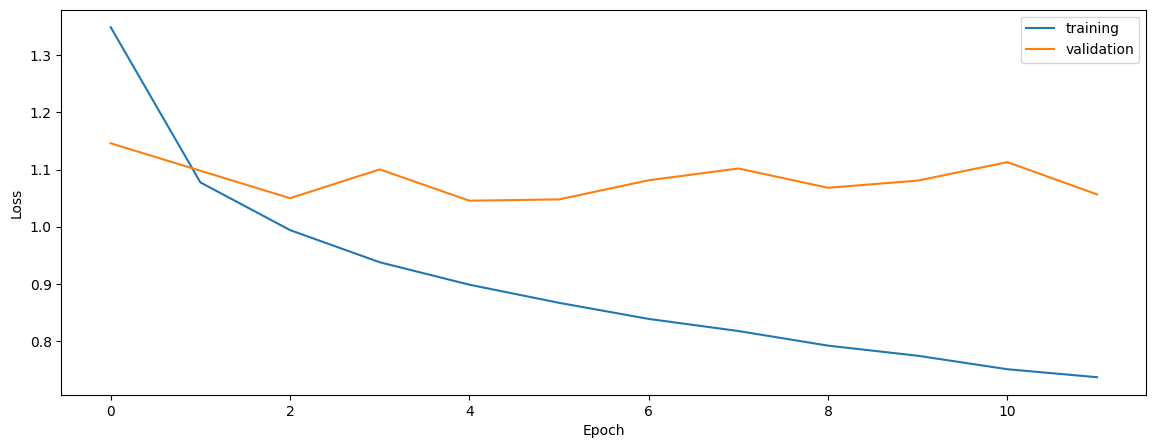

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6653326944869075
0.5881437038057992
0.598945756932605


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6111384896189824
0.5899714931153184
0.5556367523231971


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6118058964884628
0.5842226867642205
0.5558082243699072


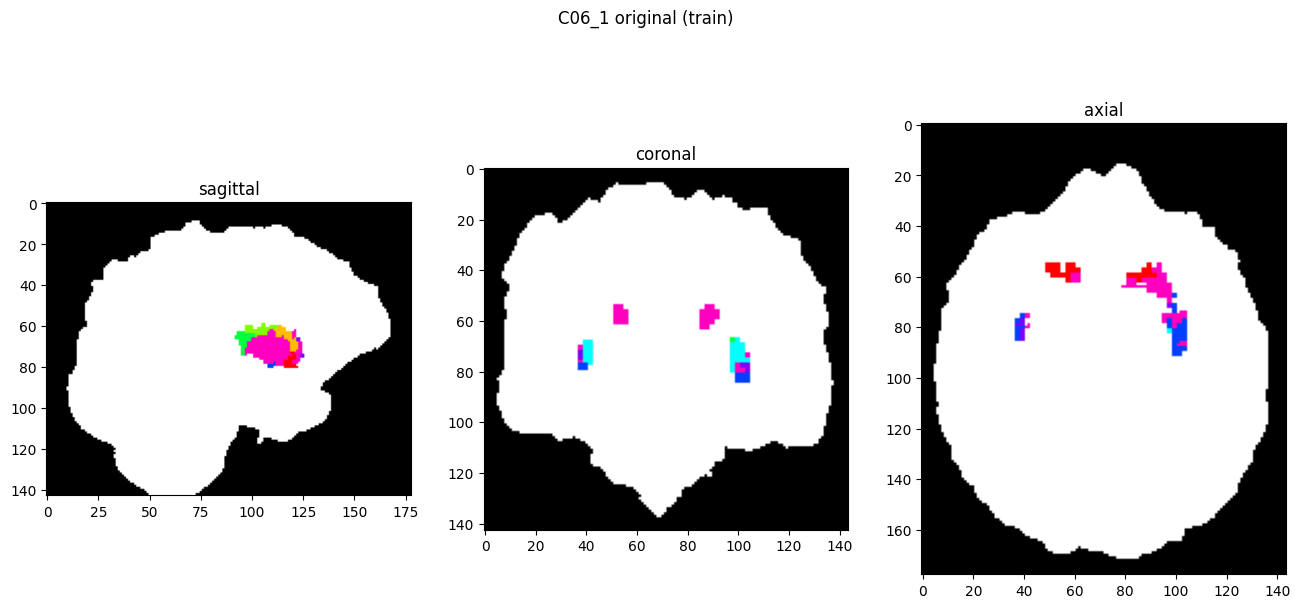

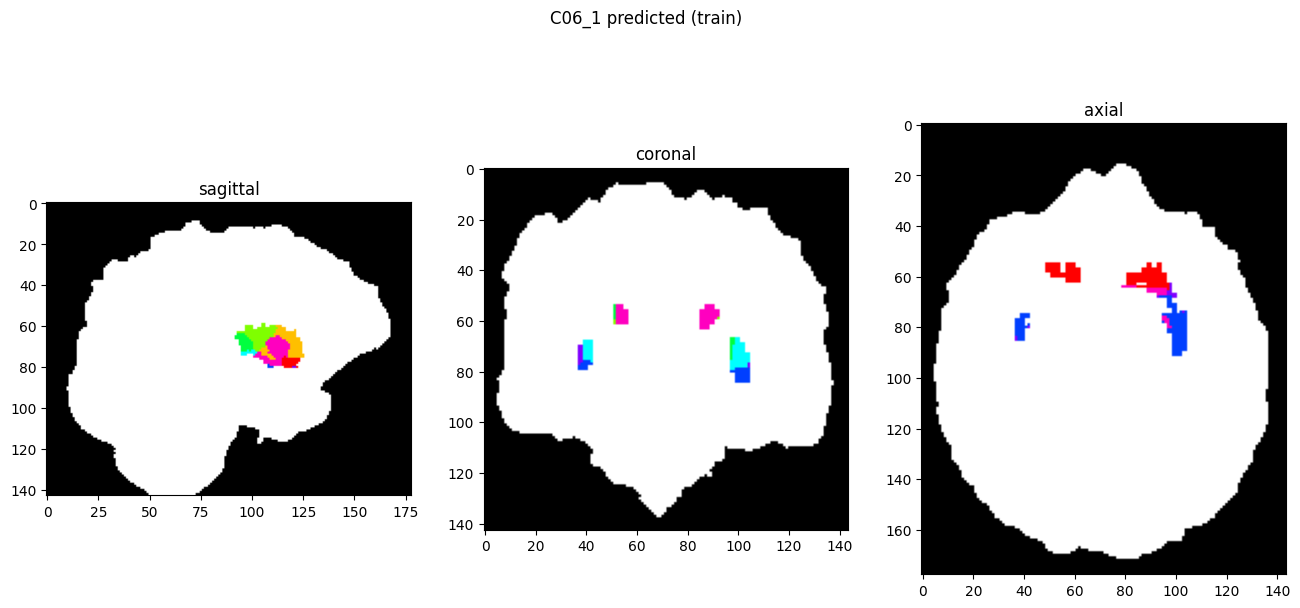

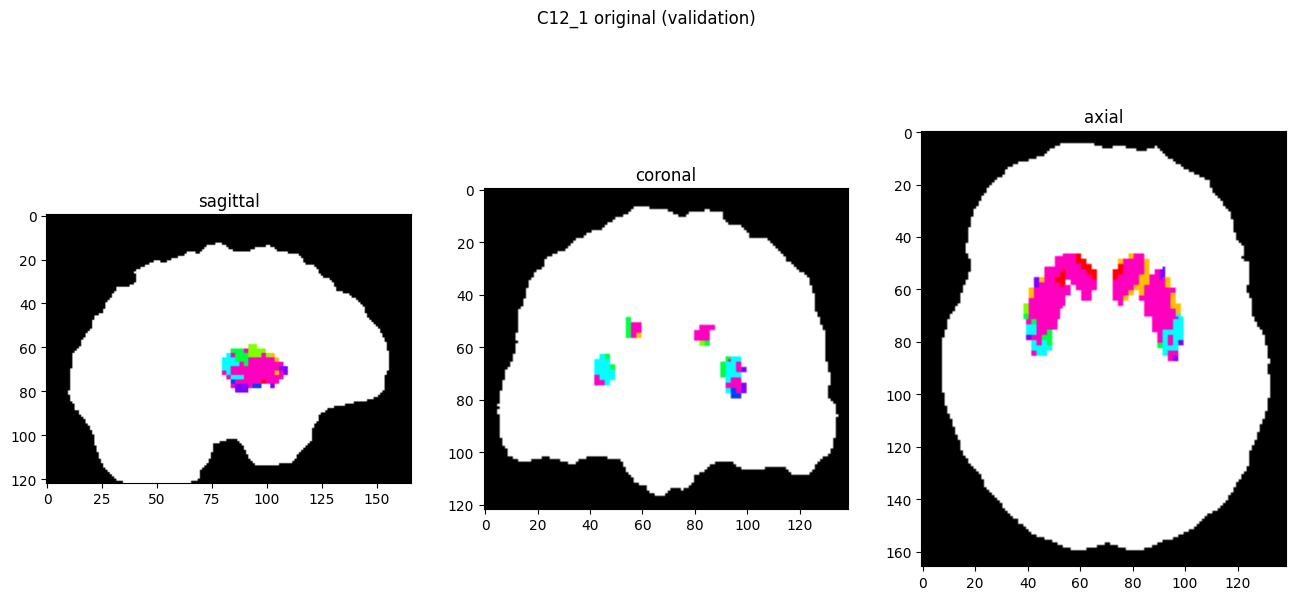

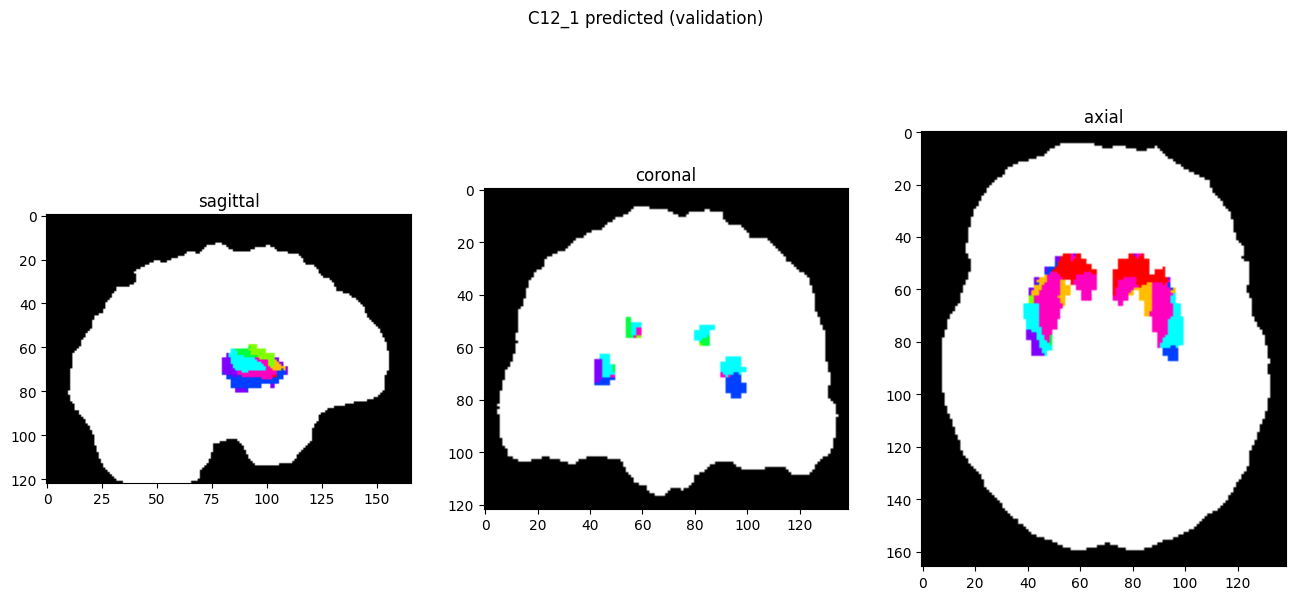

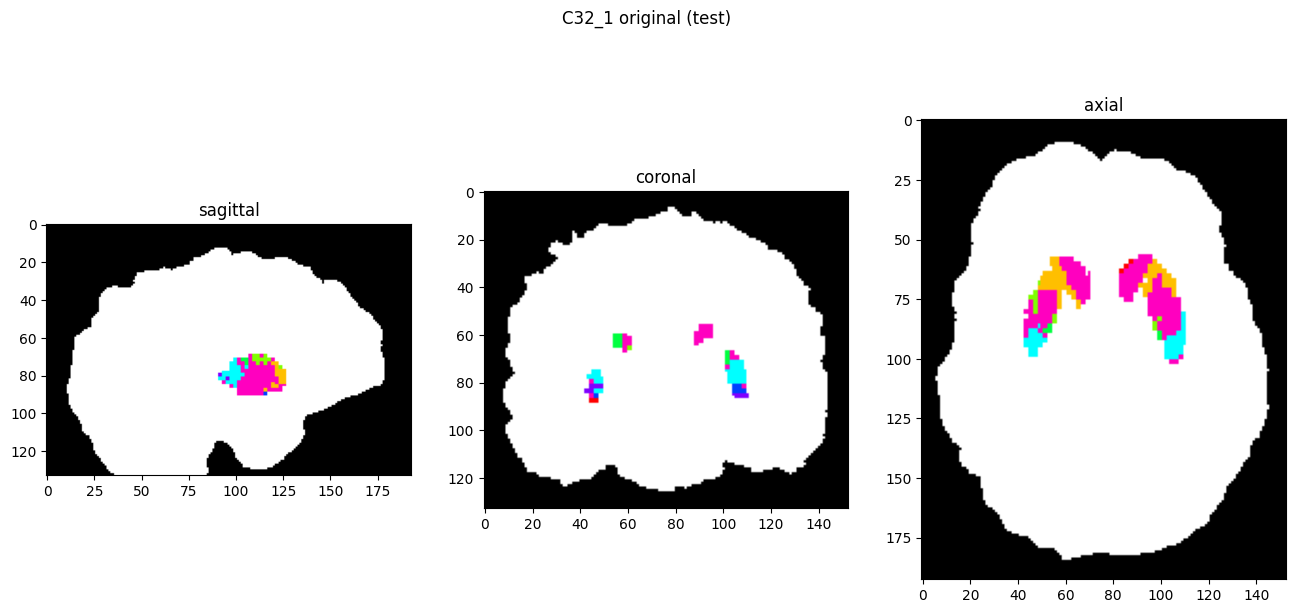

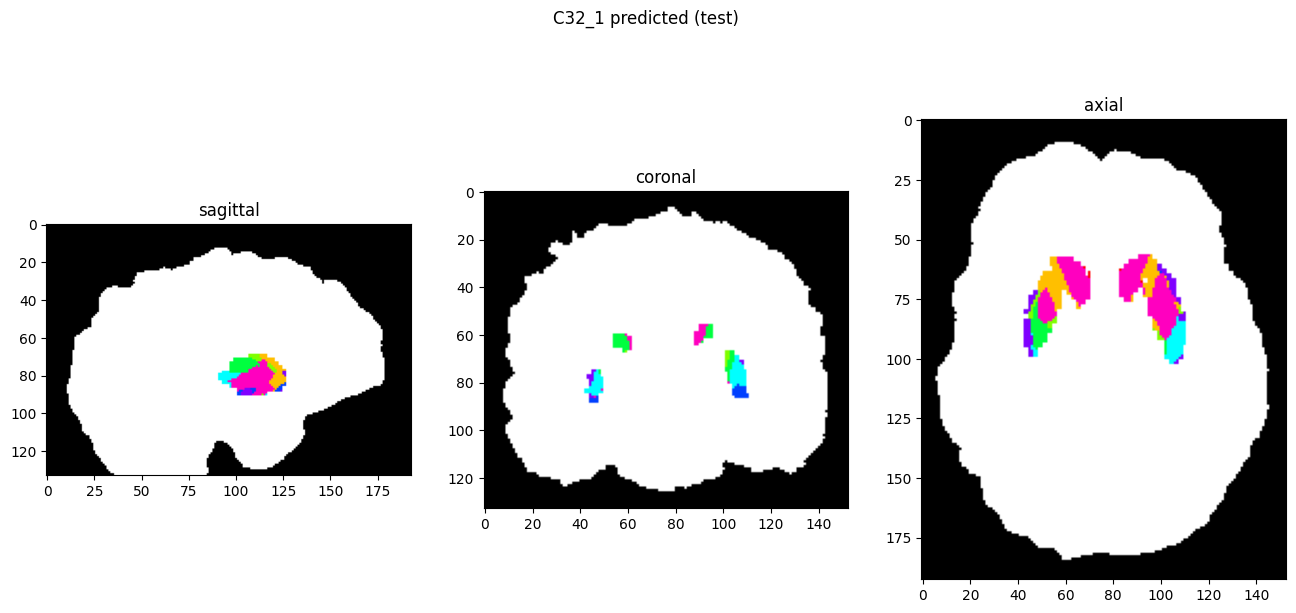

In [10]:
showResults(model, gen, threshold=0)